# <font color='darkblue'>ASTR 21100/31200

# <font color='darkblue'>"Computational Techniques in Astrophysics"
    
    
# <font color='darkblue'>Function approximation methods: polynomial interpolation

## <font color='darkblue'>Instructor: Andrey Kravtsov

In [1]:
from timeit import default_timer


In [2]:
import numpy as np 

# use jupyter "magic" command to tell it to embed plot into the notebook 
import matplotlib.pyplot as plt
%matplotlib inline

from codes.plotting import plot_prettier, plot_line_points
plot_prettier()

### <font color='darkblue'>Function approximating methods

Approximating a function that is represented by a finite number of discrete tabulated values or measurements. In each case, there is some uncertainty associated with function values: by *tabulated values* we mean function values computed as accurately as *machine precision* allows. By measurements we mean values of function measured in some way with associated uncertainties usually much larger than the accuracy that is allowed by machine precision. 

### <font color='darkblue'>General approach for approximating function $f(x)$:

1. Define ***training*** and ***test (aka validation)*** sets of values of the function variable $\{x_{i,\rm train}\}$ and $\{x_{j,\rm test}\}$. Evaluate function at these to get $\{f_{i,\rm train}\}=\{f(x_{i,\rm train})\}$ and $\{f_{j,\rm test}\}=\{f(x_{j,\rm test})\}$ function values. Brackets $\{\}$ indicate that we have a series of values, not just one. 


2. Choose an easier to compute approximation function to approximate the actual (computationally expensive) function.


3. Use the function values $\{f_{i,\rm train}\}$ calculated for the training set of parameter values in step 1 to calculate parameters of the approximating function $f_{\rm approx}(x)$.

    
4. *Test* (*validate*) the accuracy of the approximation by comparing values of the approximating function at the values of $x_{j,\rm test}$ using absolute or fractional error: $f_{j,\rm test}-f_{\rm approx}(x_{j,\rm test})$ or $f_{\rm approx}(x_{j,\rm test})/f_{j,\rm test}-1$. 
    
    
In the notebooks 05 and 06 we will consider specific choices for the approximating function: a *global* polynomial form for $f_{\rm approx}(x)$ or piece-wise polynomial representation where $f_{\rm approx}(x)$ is represented by a sum of polynomials which are defined only over a sub-interval of $x$ are are 0 elsewhere. 

### <font color='darkblue'>Interpolation vs regression
    
There are two main types of function approximation: interpolation vs regression. 
    
Interpolation matches the training values of the function to the level machine precision allows.
    
Regression aims to approximate the overall behavior of the training points, but does not match their values. Instead it minimizes the differences between training values and approximation using some metric. 



### <font color='darkblue'>The choice of approximating functions that we have already used in the schemes approximating first derivative and integral 

*Piecewise-linear* approximation using in the trapezoidal integration scheme $T(h)$. 

*Piecewise-quadratic* approximation using Simpson scheme $R_1(h)=[4T(h/2)-T(h)]/3$. 

*Piecewise-cubic* approximation of integrated function is used in Boole scheme $R_2(h)=[16R_1(h/2)-R_1(h)]/15$

etc.

### <font color='darkblue'>Approximation for the distance function $d_L$: setting up "training" and "test" data 
    
Here is an example of the piece-wise linear interpolation of $d_L$. Piece-wise 

In [3]:
from astropy.cosmology import LambdaCDM
import astropy.units as u

def d_l_astropy(z, H0, Om0, OmL):
    cosmo = LambdaCDM(H0=H0, Om0=Om0, Ode0=OmL)
    return cosmo.luminosity_distance(z=z) / u.Mpc

In [4]:
ntrain, ntest = 5, 1000 # number of the training set and test points
om0train = np.linspace(0., 1., ntrain)
om0test = np.linspace(0., 1., ntest+1)

z=0.1
# evaluate d_L at training points
dltrain = np.empty_like(om0train)
for i, omd in enumerate(om0train):
    dltrain[i] = d_l_astropy(z, 70., omd, 1.-omd)
    
# evaluate d_L at test points
dltest = np.empty_like(om0test)
for i, omd in enumerate(om0test):
    dltest[i] = d_l_astropy(z, 70., omd, 1.-omd)

# construct piecewise linear approximation using training points
# evaluate this approximation at test points and store in dlpwlin
dlpwlin = np.interp(om0test, om0train, dltrain)

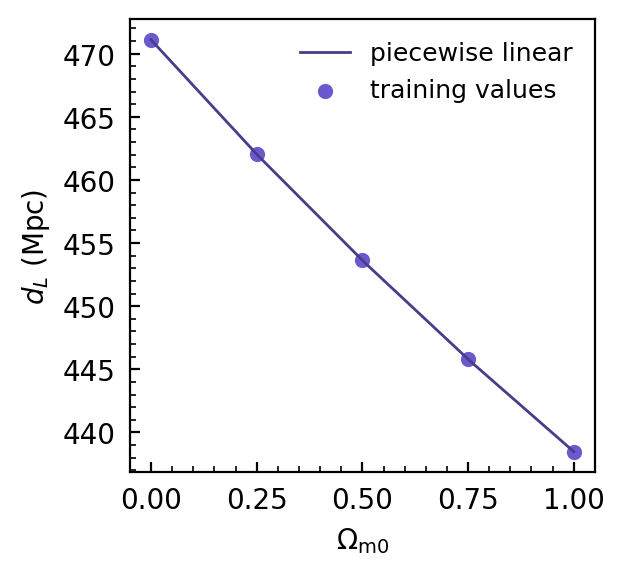

In [5]:
plot_line_points(om0test, dlpwlin, xp=om0train, yp=dltrain, points=True,
                 xlabel=r'$\Omega_{\rm m0}$', ylabel=r'$d_L\rm\ (Mpc)$', 
                 legend='piecewise linear', plegend='training values',
                 legendloc='upper right', figsize=3, psize=80)

Plot the fractional error of the piece-wise linear approximation

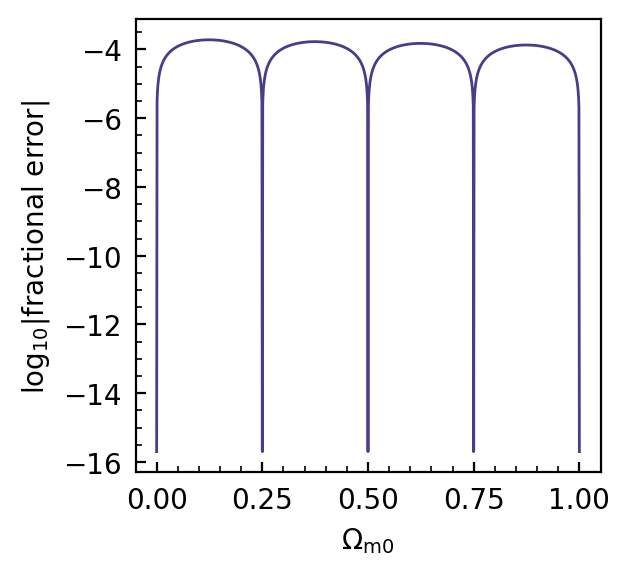

In [6]:
plot_line_points(om0test, np.log10(np.maximum(2.e-16,np.abs(1.-dlpwlin/dltest))), 
                 xlabel=r'$\Omega_{\rm m0}$', ylabel=r'$\log_{10}\vert\rm fractional\ error\vert$', 
                 legendloc='lower right', figsize=3)

Here are explitit functions that do linear interpolation. The interpolation is not implemented in the most efficient way here, but they do the same job as <tt>np.interp</tt> and are provided so you can see what kind of calculations 

In [7]:
def piecewise_linear_coefficients(xi, fi):
    """
    piecewise linear approximation of f(x) given input of training values of xi and fi
    note that xi are expected in ascending order
    """
    n = np.size(xi) - 1
    # constant values are just values of the function at x_i
    a = fi[:-1] 
    b = np.zeros_like(fi)
    # next line is equivalent to loop computing b[i] = (fi[i+1] - fi[i]) / (xi[i+1] - xi[i])
    b = np.diff(fi) / np.diff(xi)
    return a, b

In [8]:
def piecewise_linear(x, xi, fi):
    """
    piecewise linear approximation of f(x) given input of tabulated 
    "training values" of xi and fi
    note that xi are expected in ascending order
    """
    # make sure xi are in ascending order
    xi, fi = np.sort(xi), fi[np.argsort(xi)]
    a, b = piecewise_linear_coefficients(xi, fi)
    
    n = np.size(xi) - 1
    fx = dfdx = np.empty_like(x)
    for i in range(n):
        inds = (x >= xi[i]) & (x < xi[i+1])
        dfdx[inds] = b[i]
        # reusing computations is always a good idea, but here we also can return derivative dfdx
        fx[inds] = a[i] + b[i] * (x[inds] - xi[i])
    fx[-1] = fi[-1] # handle end-point
    # output function values and derivatives at x
    return fx, dfdx

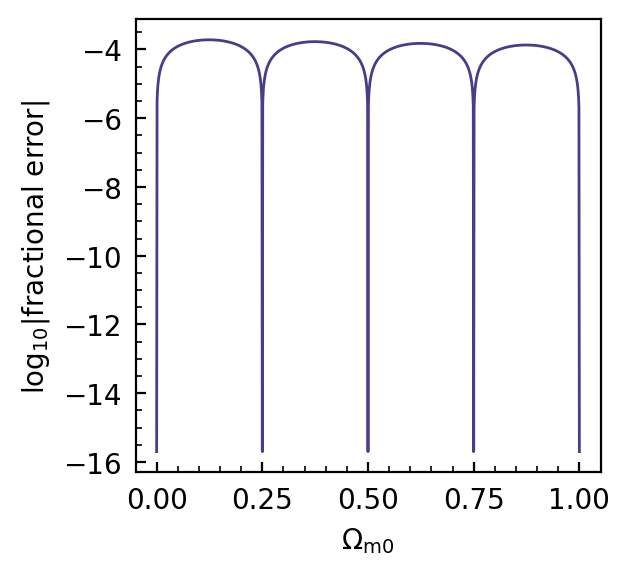

In [9]:
# you can check the functions above using explicit function that can be found in the notebook
dlpwlin, dummy = piecewise_linear(om0test, om0train, dltrain)

plot_line_points(om0test, np.log10(np.maximum(2.e-16,np.abs(1.-dlpwlin/dltest))), 
                 xlabel=r'$\Omega_{\rm m0}$', ylabel=r'$\log_{10}\vert\rm fractional\ error\vert$', 
                 legendloc='lower right', figsize=3)

### <font color='darkblue'>Approximation by a piecewise quadratic function 
    
Can be constructed using subsequent 3 training points to define 3 coefficients of the quadratic function for each interval $[x_i, x_{i+1}]$: 

$$f(x)\approx a + bx + cx^2 = a_0 + a_1x + a_2x^2$$


### <font color='darkblue'>Approximation by a linear or quadratic function are special cases of a general polynomial approximation  

$$f(x)\approx a_0 + a_1x + a_2x^2 + \ldots a_m x^m = \sum\limits_{k=0}^m a_k x^k,$$

where $a_k$ are some coefficients to be determined and are sometimes called *components* of $f(x)$. 



### <font color='darkblue'>Approximating functions: interpolation vs regression

If we have a training set of $N+1$ function values, $f_i=d_L(x_i)$, at points $\{x_i\}$ ($i=0,\dots,N$), we can construct approximation using expansion of the order $m\leq N$ 

* **Interpolation:** $m=N$ and we require approximating function to match each training set value $f_i$ to machine precision. 

The problem is fully determined  because we have $N+1$ tabulated training values, $f_i$, to constrain $N+1$ $a_k$ coefficients. This can be done by solving the linear system of equations using some method. 

* **Regression:** $m\leq N$ and we do not require approximating function to match any of the training $f_i$ values. 

In this case, coefficients are determined using a set of conditions usually stemming from the least squares constraint (more on this later). In regression we can take into account uncertainties of $f_i$, if needed, using individual weights $w_i$, which are usually defined as $w_i=1/\sigma^2_i$, where $\sigma_i$ is uncertainty of $f_i$. 

### <font color='darkblue'>Approximating $d_L(\Omega_{\rm m0})$ using polynomial

denoting $x=\Omega_{\rm m0}$ for convenience, $x^k$ (*monomial* basis): 

$$d_L = \sum\limits_{i=0}^{p}a_i x^i = a_0 + a_1 x + a_2 x^2 +\ldots + a_p x^p
$$

### <font color='darkblue'>Interpolation with a polynomial. 

The linear system of $N+1$ equations 

\begin{eqnarray}
f_{0} &=&  a_0 + a_1 x_0 + a_2 x^2_0 +\ldots + a_N x^N_0\\
f_{1} &=&  a_0 + a_1 x_1 + a_2 x^2_1 +\ldots + a_N x^N_1\\
\ldots & & \ldots\\
f_{N} &=&  a_0 + a_1 x_N + a_2 x^2_N +\ldots + a_N x^N_N\\
\end{eqnarray}
    
This is what is known as a *system of equations*. Equations are interdependent because they involve the same set of coefficients ${a_i}$. Such systems of equations are solved using methods of the *linear algebra* that deals with operations on vectors and matrices. This is because the system of equations above can be written in the matrix form ${\bf f} = {\bf V}\cdot {\bf a}$, where ${\bf f}$ and ${\bf a}$ are vectors of $f$ and $a$, while  ${\bf V}$ is $N\times N$ matrix of $x^k_i$ values.
    
$$\mathbf{f}=\begin{bmatrix}
f_0  \\
f_1 \\
\vdots \\
f_N
\end{bmatrix}=\mathbf{V}\mathbf{a}=\begin{bmatrix}
1 & x_0 & x_0^2 & \ldots & x_0^N \\
1 & x_1 & x_1^2 & \ldots & x_1^N \\
\vdots & & \ddots & & \vdots\\
1 & x_N & x_N^2& \dots& x_N^N 
\end{bmatrix}\begin{bmatrix}
a_0  \\
a_1 \\
\vdots \\
a_N
\end{bmatrix},$$ 

where  $\mathbf{V}$ is called the Vandermode matrix after French mathematician <a href="https://en.wikipedia.org/wiki/Alexandre-Th%C3%A9ophile_Vandermonde">Alexandre-Théophile Vandermonde</a> (1735-1796).


$$
\mathbf{V}=
\begin{bmatrix}
1 & x_0 & x_0^2 & \ldots & x_0^N \\
1 & x_1 & x_1^2 & \ldots & x_1^N \\
\vdots & & \ddots & & \vdots\\
1 & x_N & x_N^2& \dots& x_N^N 
\end{bmatrix}
$$

### <font color='darkblue'>Solving the system of equations 

* To solve the system of linear equations  arising in the problem of approximating functions by a polynomial the most common methods use so-called <a href="https://en.wikipedia.org/wiki/LU_decomposition">LU</a> or <a href="https://en.wikipedia.org/wiki/QR_decomposition">QR</a> matrix decomposition methods or the <a href="https://en.wikipedia.org/wiki/Singular_value_decomposition">Singular Value Decomposition</a> (SVD) method. The LU decomposition is used in <a href="https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html"><tt>np.linalg.solve</tt> function</a> which should be used to solve such systems of equations. 
    
***Note:*** You don't need to understand these methods. We do not have the time to go over them in this course. However, they are well developed and established with reliable functions available that implement them. 

SVD is used in <tt>numpy.linalg.lstsq</tt> for least squares regression that will be discussed later. 

Understanding these methods is not required for our purposes. Just knowledge that methods much more stable than direct inversion of $\mathbf{V}$ will suffice. 

Now let's apply the same approach to approximate $d_L$ as a function of $\Omega_{\rm m0}$, but using <a href="https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html"><tt>np.linalg.solve</tt> function</a>. 

For illustration purposes we will assume a "geometrically flat" universe, in which $\Omega_\Lambda = 1-\Omega_{\rm m0}$ and we will keep $H_0$ fixed at 70 and $z$ fixed at 0.1, which makes $d_L$ a function of $\Omega_{\rm m0}$ only.  

In [10]:
ntrain = 2000 # number of the training set points
om0train = np.linspace(0., 1., ntrain)

dltrain = np.empty_like(om0train)
# compute d_l values at training points 
for i, omd in enumerate(om0train):
    dltrain[i] = d_l_astropy(0.1, 70., omd, 1.-omd)

In [11]:
vmat = np.vander(om0train, N=ntrain, increasing=True) # set up the Vandermonde matrix

a = np.linalg.solve(vmat, dltrain) # solve system of linear equations for coefficients a
# object for polynomial with coefficients a 
# [::-1] reverses order of the coefficients, as required by this function
pfit = np.poly1d(a[::-1]) 

In [12]:
ntest = 1000 # number of the test points
om0test = np.linspace(0., 1., ntest+1)
dltest = np.empty_like(om0test)
for i, omd in enumerate(om0test):
    dltest[i] = d_l_astropy(0.1, 70., omd, 1.-omd)
    
dlpoly = pfit(om0test)

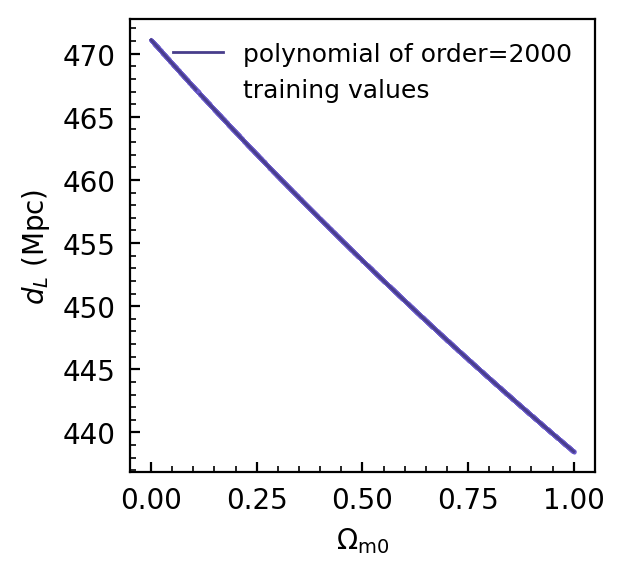

In [13]:
plot_line_points(om0test, dlpoly, xp=om0train, yp=dltrain, points=True,
                 xlabel=r'$\Omega_{\rm m0}$', ylabel=r'$d_L\rm\ (Mpc)$', 
                 legend='polynomial of order=%d'%ntrain, plegend='training values',
                 legendloc='upper right', figsize=3, psize=1)

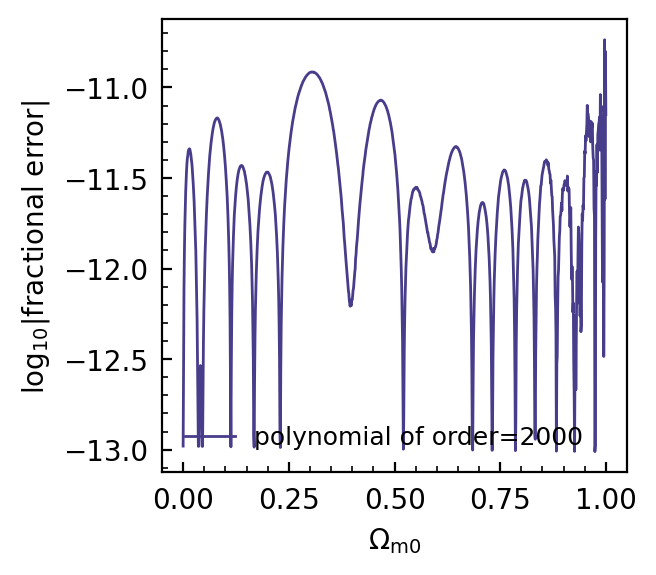

In [14]:
plot_line_points(om0test, np.log10(np.maximum(np.abs(1.-dlpoly/dltest), np.abs(dlpoly)/2**52)),
                 xlabel=r'$\Omega_{\rm m0}$', ylabel=r'$\log_{10}\vert\rm fractional\ error\vert$', 
                 legend='polynomial of order=%d'%ntrain, plegend='training values',
                 legendloc='best', figsize=3)

So we were able to construct an interpolating polynomial of 2000th order! 

***It's pretty accurate, but at the same time the fractional error is quite far from the "machine precision limit" of $2\times 10^{-16}$. We could expect better from a polynomial of 2000th degree approximating a nearly linear function!***

Here again we are facing the situation where a large number of algebraic operations limits the accuracy of the result to much lower value than the minimal fractional accuracy of $\approx 2\times 10^{-16}$. 

### <font color='darkblue'>Function for polynomial approximation

The function below implements piecewise linear (<tt>method=pwlin</tt>) or polynomial expansion.
Numpy has a function for polynomial expansion interpolation <tt>np.polyfit</tt>, which returns an instance of an object (class) initialized with the training set of points and corresponding values of our function. 


This function is used below to do polynomial interpolations. 

In [15]:
from scipy.interpolate import interp1d

def poly_fit_func(xtrain, ytrain, xtest, method='poly', porder=None, sporder=3):
    """A helper function to perform piecewise linear or polynomial interpolation and regression
    
    Parameters:
        xtrain, ytrain: 1d numpy vectors of floats containing training x_i,train values 
                        and corresponding function values f(x_i,train)
        xtest: 1d numpy vector of test/validation x values at which to evaluate approximation
        method: str, 'pwlin' - piecwise linear, 'poly' - polynomial approximation
        porder: int, <= xtrain.size - order of the approximating polynomial, 
                default = None, for which order is equal to the number of training points
                for values in the range [1,ntrain] will return approximating polynomial
    """
    
    if method == 'pwlin': # piecewise linear approximation
        return np.interp(xtest, xtrain, ytrain)
    
    elif method == 'poly': # polynomial interpolation or regression
        ntrain = np.size(ytrain)
        if porder is None: # if polynomial order is not supplied, assume we are interpolating
            porder = ntrain
        assert(porder <= ntrain) # make sure that order is smaller than the size of the training sample
        polyfit = np.polyfit(xtrain, ytrain, porder) # compute polynomial coefficients by solving system of normal equations
        pfit = np.poly1d(polyfit) # initialize 1d polynomial class with these coefficients
        return pfit(xtest) # return polynomial values at test points
    

### <font color='darkblue'>Extrapolation

If we use $\tilde{f}(x)$ constructed using one of these approaches for $x<x_0$ or $x>x_N$, this is called ***extrapolation***.

**Warning!** In general extrapolation is dangerous and should not be used as it can result in catastrophic errors, except in special cases, when an informed extrapolation can be made. 
    
Experiment below shows that if $d_L$ calculation is trained for $\Omega_{\rm m0}\in [0,1]$, extrapolating to $\Omega_{\rm 0}$ would give a huge error. 

In [16]:
print('d_L for Om0=5 is {:.3f} Mpc'.format(d_l_astropy(0.1, 70., 5., 0.7)))

d_L for Om0=5 is 411.586 Mpc


In [17]:
def compute_dl_train(om0train, om0test, z=0.1, H0=70., oml=0.7):
    """
    compute d_l using Astropy function for input training points (om0train) and test points (om0test)
    
    Parameters: om0train and om0test - float numpy arrays
    Returns: float numpy vectors dltrain, dltest, dlpoly (polynomial approximation at test points)
            corresponding to om0train, om0test values 
    """

    # evaluate d_L at training points
    dltrain = np.empty_like(om0train)
    for i, omd in enumerate(om0train):
        dltrain[i] = d_l_astropy(z, H0, omd, 1.-omd)

    # evaluate d_L at test points
    dltest = np.empty_like(om0test)
    for i, omd in enumerate(om0test):
        dltest[i] = d_l_astropy(z, H0, omd, 1.-omd)
        
    # compute polynomial approximation at test points 
    dlpoly = poly_fit_func(om0train, dltrain, om0test)
    
    return dltrain, dltest, dlpoly

In [18]:
om0test_ex = np.linspace(0.,5.,1000)
om0train =  np.linspace(0.,5.,10)

dltrain, dltest, dlpoly = compute_dl_train(om0train, om0test_ex)
dlpoly_ex  = poly_fit_func(om0train, dltrain, om0test_ex)

C:\Users\akrav\miniconda3\lib\site-packages\astropy\units\quantity.py:1262: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self.to_value(dimensionless_unscaled))
C:\Users\akrav\AppData\Local\Temp\ipykernel_14836\3159637575.py:21: RankWarning: Polyfit may be poorly conditioned
  dlpoly = poly_fit_func(om0train, dltrain, om0test)
C:\Users\akrav\AppData\Local\Temp\ipykernel_14836\2313133690.py:5: RankWarning: Polyfit may be poorly conditioned
  dlpoly_ex  = poly_fit_func(om0train, dltrain, om0test_ex)


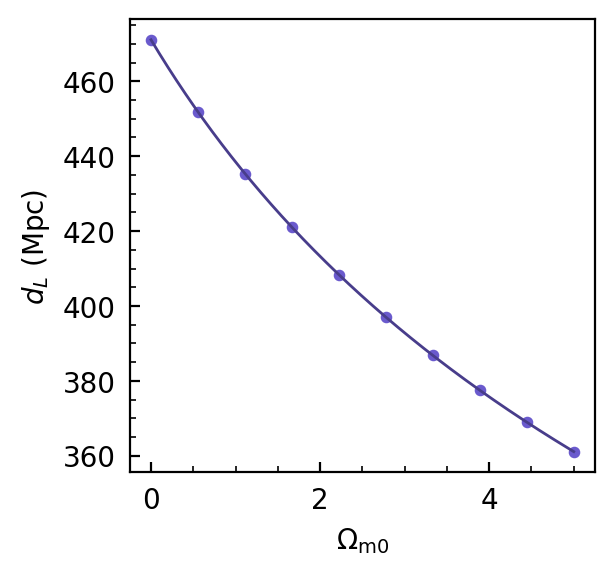

In [19]:
plot_line_points(om0test_ex, dlpoly_ex, xp=om0train, yp=dltrain, points=True, psize=40, 
                 xlabel=r'$\Omega_{\rm m0}$', ylabel=r'$d_L\rm\ (Mpc)$', figsize=3)

### <font color='darkblue'>The general rule of extrapolation


# <font color='darkblue'>DON'T!$^\star$


$^\star$ Unless you have a good mathematical or physics-based model for how your function should behave outside the approximation interval.

## <font color='darkblue'>Polynomial approximation using non-even spacing of training points 

If there is a choice of where to place training values within the interval where function is approximating, there is an optimal choice for such placement that produces much more accurate and numerically stable results than for evenly spaced training values.
    
The optimal choice is to place training values at the so-called Chebyshev nodes, as shown below. 
Explanation and justification of why this choice works much better is beyond the scope of undegraduate course, but is available below in the material for graduate students. 


### <font color='darkblue'>Chebyshev interpolation nodes 

Chebyshev nodes are either *roots (zeros) or extrema (maxima and minima) of the <a href="https://en.wikipedia.org/wiki/Chebyshev_polynomials">Chebyshev polynomials</a>.* 

There are two kinds of Chebyshev polynomials and, correspondingly, two sets of nodes: Chebyshev nodes of the 1st and 2nd kind. 

Geometrically, these nodes can be obtained by placing equidistant points on the upper half of the circle of unit radius and projecting them onto $x$ axis.  The projection creates point distribution with density increasing towards the edges of the interval. The 1st and 2nd kind differ in where the equidistant points are placed.

Equivalently, we can set up angles using eqal step in angle and the Chebyshev nodes will be cosines of these angles.

<img width=600 src="https://astro.uchicago.edu/~andrey/classes/a211/img/Chebyshev-nodes-by-projection.png"></img>

### <font color='darkblue'>Chebyshev nodes of the first kind

$N+1$ Chebyshev nodes of the 1st kind on the interval $[-1,1]$ are defined as

$$x_i=\cos\left[\frac{(2i+1)}{2N+2}\,\pi\right],\ \ \ \ i=0,\ldots,N$$

Their barycentric weights are known:

$$w_i=(-1)^i\,\sin\left[\frac{(2i+1)}{2N+2}\,\pi\right],\ \ \ \ i=0,\ldots,N.$$

### <font color='darkblue'>Chebyshev nodes of the second kind

$N+1$ Chebyshev nodes of the 2nd kind on the interval $[-1,1]$ are defined as

$$x_i=\cos\frac{i}{N}\,\pi,\ \ \ \ i=0,\ldots,N$$

The expression for the barycentric weights $w_i$ for these nodes are are especially simple:

$$w_i=(-1)^i\delta_i;$$

where $\delta_i=1/2$ for $i=0$ or $i=N$, and $\delta_i=1$ otherwise. 

### <font color='darkblue'>Rescaling Chebyshev nodes to an arbitrary interval $[a,b]$

Chebyshev nodes are defined for the interval $[-1,1]$, but once they are generated for this interval, they can be rescaled to the required interval $[a,b]$ as 

$$x_i=a + \frac{(b-a)}{2}(1+x_{i,\rm Cheb}),$$

where $x_{i,\rm Cheb}$ are the Chebyshev nodes (1st or 2nd kind) defined on the interval $[-1,1]$.

The barycentric weights $w_i$ stay the same for any interval. 

Formally, the weights get rescaled by $2^N(b-a)^N$ when nodes are rescaled from $[-1,1]$ to $[a,b]$. However, given that this rescaling factor does not depend on $i$ it cancels out in the barycentric interpolation formula, so whether it is included or not does not change this formula. 

In [20]:
# functions generating N+1 Chebyshev nodes of the 1st and 2nd kind 
# for input N, and interval edges a and b

def chebyshev_nodes1(a, b, N):
    return a + 0.5*(b-a)*(1. + np.cos((2.*np.arange(N+1)+1)*np.pi/(2.*(N+1))))

def chebyshev_nodes2(a, b, N):
    return a + 0.5*(b-a)*(1. + np.cos(np.arange(N+1)*np.pi/N))

### <font color='darkblue'>Let's experiment with polynomial interpolation as an approximation for distance $d_L$ as a function of $\Omega_{\rm m0}$

In [21]:
ntrain, ntest = 10, 5000 # number of the training set and test points
om0min, om0max = 0., 1.
# test points will be the same for all schemes
om0test = np.linspace(om0min, om0max, ntest+1)

# evenly spaced training points
om0train_e = np.linspace(om0min, om0max, ntrain)
dltrain_e, dltest_e, dlpoly_e = compute_dl_train(om0train_e, om0test) 

# Chebyshev nodes of the 1st kind 
om0train_c1 = chebyshev_nodes1(om0min, om0max, ntrain)
dltrain_c1, dltest_c1, dlpoly_c1 = compute_dl_train(om0train_c1, om0test) 

# Chebyshev nodes of the 2nd kind 
om0train_c2 = chebyshev_nodes2(om0min, om0max, ntrain)
dltrain_c2, dltest_c2, dlpoly_c2 = compute_dl_train(om0train_c2, om0test) 


C:\Users\akrav\AppData\Local\Temp\ipykernel_14836\3159637575.py:21: RankWarning: Polyfit may be poorly conditioned
  dlpoly = poly_fit_func(om0train, dltrain, om0test)
C:\Users\akrav\AppData\Local\Temp\ipykernel_14836\3159637575.py:21: RankWarning: Polyfit may be poorly conditioned
  dlpoly = poly_fit_func(om0train, dltrain, om0test)
C:\Users\akrav\AppData\Local\Temp\ipykernel_14836\3159637575.py:21: RankWarning: Polyfit may be poorly conditioned
  dlpoly = poly_fit_func(om0train, dltrain, om0test)


In [22]:
# fractional error of the polynomial approximation for evenly spaced training points
frac_err_poly_e   = np.log10(np.maximum(np.abs(1.0-dlpoly_e/dltest_e), 2.e-16))
# fractional error of the polynomial approximation for Chebyshev 1 training points
frac_err_poly_c1  = np.log10(np.maximum(np.abs(1.0-dlpoly_c1/dltest_c1), 2.e-16))
# fractional error of the spline approximation for Chebyshev 2 training points
frac_err_poly_c2 = np.log10(np.maximum(np.abs(1.0-dlpoly_c2/dltest_c2), 2.e-16))

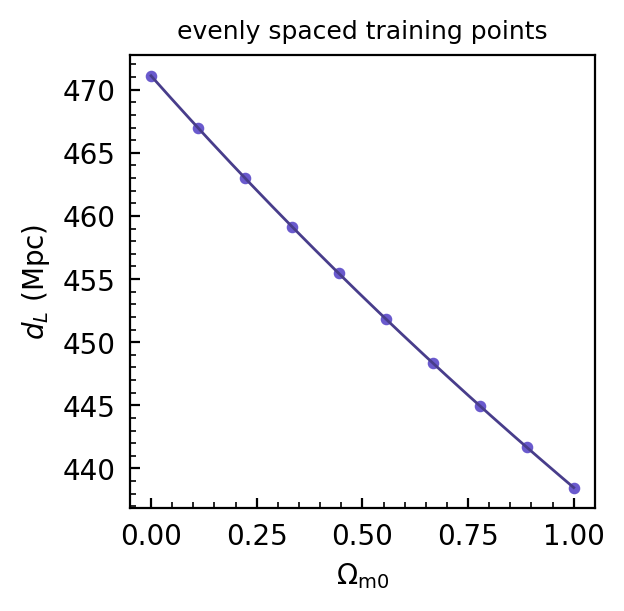

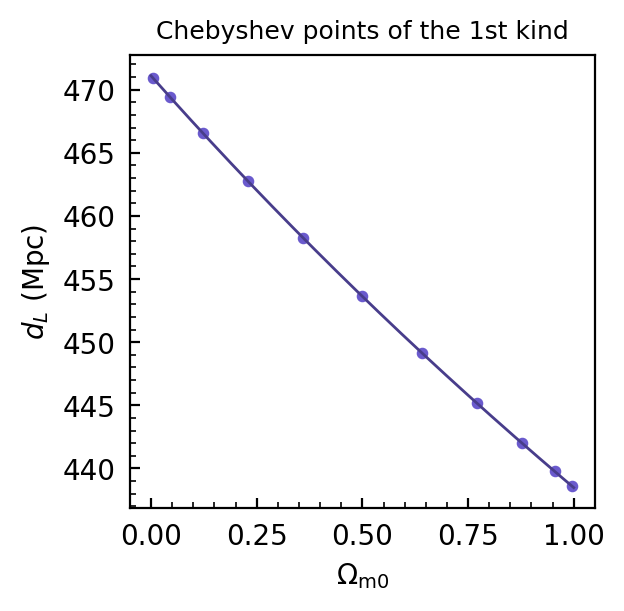

In [23]:
plot_line_points(om0test, dltest_e, xp=om0train_e, yp=dltrain_e, points=True, psize=40, 
                 plot_title='evenly spaced training points',
                 xlabel=r'$\Omega_{\rm m0}$', ylabel=r'$d_L\rm\ (Mpc)$', figsize=3)

plot_line_points(om0test, dltest_c1, xp=om0train_c1, yp=dltrain_c1, points=True, psize=40, 
                 plot_title='Chebyshev points of the 1st kind',
                 xlabel=r'$\Omega_{\rm m0}$', ylabel=r'$d_L\rm\ (Mpc)$', figsize=3)


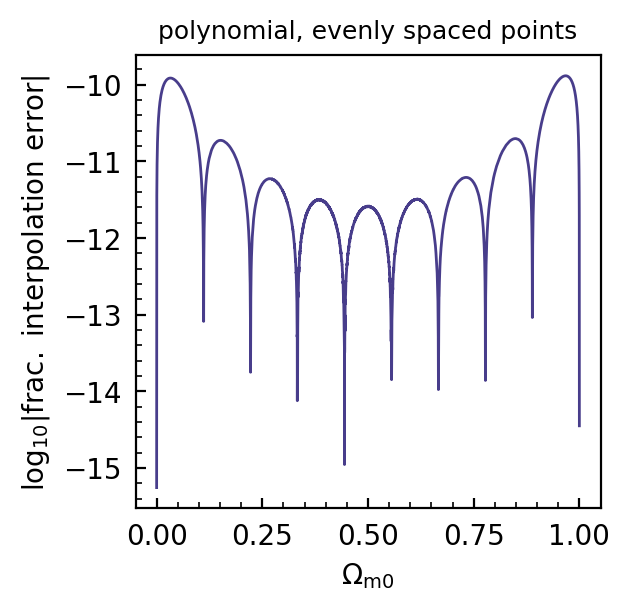

In [24]:
plot_line_points(om0test, frac_err_poly_e,
                 xlabel=r'$\Omega_{\rm m0}$', 
                 ylabel=r'$\log_{10}\vert\rm frac.\ interpolation\ error\vert$', 
                 plot_title='polynomial, evenly spaced points', figsize=3)


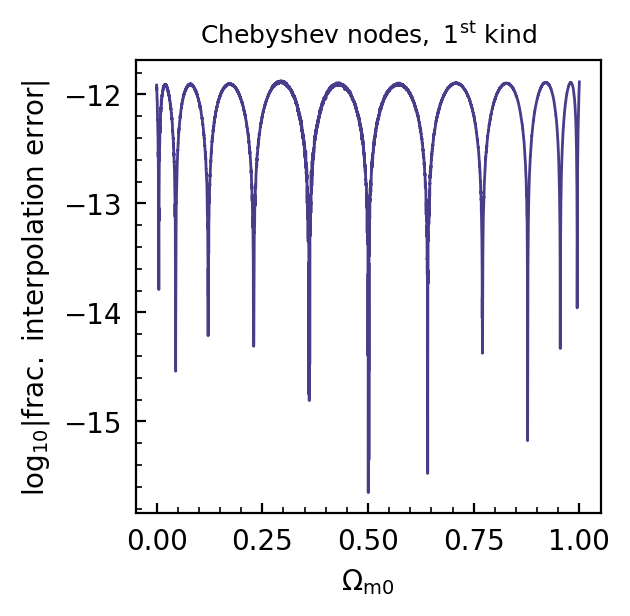

In [25]:
plot_line_points(om0test, frac_err_poly_c1,
                 xlabel=r'$\Omega_{\rm m0}$', 
                 ylabel=r'$\log_{10}\vert\rm frac.\ interpolation\ error\vert$', 
                 plot_title=r'$\rm Chebyshev\ nodes,\ 1^{st}\ kind$', figsize=3)


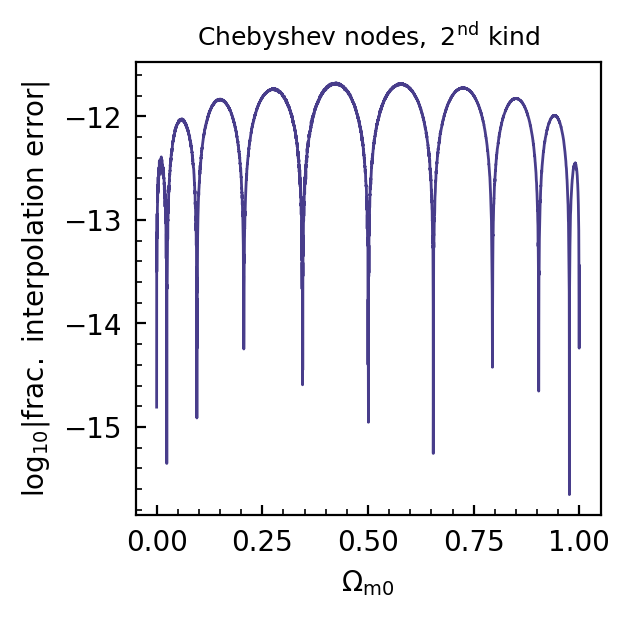

In [26]:
plot_line_points(om0test, frac_err_poly_c2,
                 xlabel=r'$\Omega_{\rm m0}$', points = False, 
                 ylabel=r'$\log_{10}\vert\rm frac.\ interpolation\ error\vert$', 
                 plot_title=r'$\rm Chebyshev\ nodes,\ 2^{nd}\ kind$', 
                 figsize=3)

### <font color='darkblue'>Conclusions:

* Interpolation with Chebyshev nodes is more accurate for the same number of interpolation nodes ("training points"): the max fractional error is smaller and is more uniform across the range of $\Omega_{\rm m0}$. The reason is that it is an optimal scheme for polynomial interpolation. The Chebyshev polynomial interpolation also supresses errors near the edges of the interval (see below). 


* Accuracy of interpolation with Chebyshev nodes of the 1st or 2nd kind is comparable. 


* For this well behaved and slowly changing function, polynomial approximation works even if we use 1000 training points (i.e. approximate with a 1000th order polynomial) although even in this case fitting function warns that the Vandermonde matrix may be ill-conditioned. For more rapidly varying functions evenly spaced interpolation generally fails for low orders due to ill-conditioned Vandermonde matrix. 


### <font color='darkblue'>Suppose we are happy with the fractional error of the polynomial approximation. How much did we gain in computational speed up?


In [27]:
from time import time

tstart = time()
for i, omd in enumerate(om0test):
    dltest = d_l_astropy(0.1, 70., omd, 0.7)

print("astropy d_l execution time = %.8g sec"%(time()-tstart))

astropy d_l execution time = 2.7539911 sec


In [28]:
# Chebyshev training points
tstart = time()
porder = np.size(om0train_c1)
pfit = np.poly1d(np.polyfit(om0train_c1, dltrain_c1, porder))
dummy = pfit(om0test)
print("np.polyfit time = %.8g sec"%(time()-tstart))

np.polyfit time = 0.0081806183 sec


C:\Users\akrav\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3361: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


### <font color='darkblue'>Conclusions

* Polynomial approximation can be highly accurate for smooth functions, such as $d_L$. 


* Accuracy is sensitive to how we approximate and, in particular, on the placement of the training tabulated parameter values.


* For the training parameter values distributed at the Chebyshev nodes, results accurate to near machine precision can be obtained for smooth functions with about 1000-fold speed up of calculation! 


***We "trained" a function to compute an integral with nearly machine precision accuracy without actually doing any explicit numerical integration!***

This is part of what ***machine learning*** is about. We approximate an integral using training data and then approximate the integral for any input values within the interval using the approximation. 

## <font color='darkblue'>The following is material for graduate students 

The main limitation of polynomial interpolation is that for high polynomial order such interpolation can be numerically unstable and impossible. 

***Note:*** in what follows, standard terminology of this area is used for training points - which are called *interpolation nodes* in these methods. This term is used below throughout this notebook. 

In the rest of the notebooks, we will use *training points* term to be consistent with terminology used in the machine learning methods. 

### <font color='darkblue'>First, what does it mean to use a different polynomial basis? 
    
We are not limited to expressing polynomial of order $N$ using the *monomials* $x^k$: 
\begin{equation}
P_N(x)= \sum\limits_{k=0}^{N}a_k x^k.
\end{equation}

    
For example, a quadratic polynomial $7-5x+x^2$ can be written  as $1+2(x-3)+(x-3)(x-4)$, which is called *the Newton form*.


We can generally express a polynomial of order $\leq N$ as: 
\begin{equation}
P_N(x)= \sum\limits_{k=0}^{N}a_k \pi_k(x),
\end{equation}

where $\pi_k(x)$ is a polynomial of order $k$ expressed in some form. Clearly, the choice of $\pi_k(x)$ will determine the form of the Vandermonde matrix and thus details of how the system of linear equations is solved for $a_k$ coefficients.

The two most commonly chosen forms for $\pi_k(x)$ are the Newton and Lagrange forms. In the former case the polynomial is computed using *method of divided differences*, while in the former *barycentric interpolation method* is used to compute interpolating polynomial. 

The Newton form is not important for what follows in this notebook, you can skip material in the next few cells related to this method, if you want. These are included for completeness. 

The Lagrange form and barycentric interpolation method are useful to know because it is this method that is used for Chebyshev polynomial interpolation. 

### <font color='darkblue'>Polynomials in the Newton form.
    
We can express polynomial of order $N$ in the *Newton form* with $\pi_0=1$, $\pi_1(x)=x-x_0$ and $\pi_k(x)=\prod_{j=1}^{k-1}(x-x_j)$, i.e.:
\begin{eqnarray}
p_N(x)&=&a_0 + a_1(x-x_0) + a_2(x-x_0)(x-x_1) +\ldots + a_N(x-x_0)\ldots (x-x_{N-1})\nonumber\\
         &=&a_0 + \sum\limits_{k=1}^N a_k\prod\limits_{j=0}^{k-1}(x-x_j).
\end{eqnarray}
Here and below $\prod_{j=0}^{k-1}$ stands for "product of terms from $0$ to $k-1$." 

It can be easily seen that the Vandermonde matrix in this case has non-zero entries only on the diagonal and below as
\begin{eqnarray}
 f(x_0) &=& a_0,\\
 f(x_1) &=&a_0 + a_1(x_1-x_0),\\
 f(x_2) &=&a_0 + a_1(x_2-x_0) + a_2(x_2-x_0)(x_2-x_1),\\ 
 f(x_N)&=&a_0 + a_1(x_N-x_0) + a_2(x_N-x_0)(x_N-x_1) +\cdots + a_N(x_N-x_0)(x_N-x_1)\cdots (x_N-x_{N-1}).
\end{eqnarray}

 The simplified $L$-form of matrix $\mathbf{V}$ allows its inversion to compute coefficients $a_k$ in $O(N^2)$ operations. Polynomial in the Newton form can be evaluated for a given $x$ in $2N$ additions plus $N$ multiplications, if the sum in the first equation above is computed using the nested form: 
\begin{equation}
p_N(x)=a_0 + (x-x_0)\left\{a_1+ (x-x_1)\left[a_2 +\ldots + (x-x_{N-2})(a_{N-1} + (x-x_{N-1})a_N)\right]\right\} \label{eq:polynested}
\end{equation}


### <font color='darkblue'>Computing Newon polynomial coefficients using divided differences
 
 In fact, there is an elegant recursive procedure for computing these coefficients. It is easy to see from above that $a_0 = f(x_0)$ and $a_1 = (f_1-f_0)/(x_1-x_0)$. To express the other coefficients, we will use notation of *divided differences*, which approximate derivatives of $f(x)$ of different order over the interval of input $x$ values: 
\begin{equation}
f[x_i] = f(x_i);\ \ \rightarrow a_0=f[x_0]; 
\end{equation}
\begin{equation}
f[x_i,x_{i+1}] = \frac{f[x_{i+1}]-f[x_i]}{x_{i+1}-x_i}= \frac{f_{i+1}-f_i}{x_{i+1}-x_i}=\frac{f_i}{x_i-x_{i+1}} +  \frac{f_{i+1}}{x_{i+1}-x_{i}}
\end{equation}
and thus
\begin{equation}
 a_1 = \frac{f(x_1)-f(x_0)}{x_1-x_0} = f[x_0,x_1]
\end{equation}
Similarly, we can define $f[x_i,x_{i+1},x_{i+2}]$ which recursively uses the divided differences defined above: 
\begin{eqnarray}
f[x_i,x_{i+1},x_{i+2}] &=& \frac{f[x_{i+1},x_{i+2}]-f[x_{i},x_{i+1}]}{x_{i+2}-x_i}\nonumber\\
&=& \frac{1}{x_{i+2}-x_i}\,\left[\frac{f_{i+2}-f_{i+1}}{x_{i+2}-x_{i+1}}-\frac{f_{i+1}-f_{i}}{x_{i+1}-x_{i}}\right]\\
&=& \frac{f_i}{(x_i-x_{i+1})(x_i-x_{i+2})} +  \frac{f_{i+1}}{(x_{i+1}-x_{i})(x_{i+1}-x_{i+2})} + \frac{f_{i+2}}{(x_{i+2}-x_{i})(x_{i+2}-x_{i+1})}.\nonumber
\end{eqnarray}
Then, with a bit of algebra we can show that 
\begin{equation}
a_2 = f[x_0,x_1,x_2] 
\end{equation}
and, in general, 
\begin{equation}
f[x_i,\ldots,x_{i+n}]=\frac{f[x_{i+1},\ldots,x_{i+n}]-f[x_i,\ldots,x_{i+n-1}]}{x_{i+n}-x_i}=\sum\limits_{j=0}^n\,\frac{f(x_{i+j})}{\prod_{k=0,k\ne j}^n(x_{i+j}-x_{i+k})}.
\end{equation}
and
\begin{equation}
a_k = f[x_0,x_1,\ldots, x_k].
\end{equation}

The divided differences of any order can thus be constructed progressively from the differences of one order lower. These differences are coefficients in the interpolating polynomial
of function $f(x)$ tabulated at $\{x_i\}_{i=0,N}$:
    
\begin{eqnarray}
f(x)\approx p_N(x)&=&f[x_0] + f[x_0,x_1](x-x_0) + f[x_0,x_1,x_2](x-x_0)(x-x_1) +\ldots \nonumber\\
         &&+ f[x_0,\ldots,x_N](x-x_0)\ldots (x-x_{N-1}). 
\end{eqnarray}

Note that for equidistant nodes, all differences $x_k-x_m=\Delta x$ are equal. In this case, the polynomial approximation above is essentially the approximate Taylor expansion
around $x_0$ with divided differences representing estimates of the derivatives of different order evaluated at $x_0$ divided by $n!$. These estimates are done in a way that guarantees
that $p_N(x)$ matches $f(x)$ at its tabulated values. 

In [29]:
def polyint_newton(xi, fi, xt):
    """
    A function to compute 1d interpolating polynomial using Newton's divided differences
    for input training set parameter values, xi and fi, and for input vector of test points xt
    using equations presented above
    
    The function is not vectorized or optimized for speed and is presented for illustration purposes
    It is quite useable, however, for practical interpolation for moderate sizes of vectors.
    """
    n = np.size(fi)
    df = np.zeros((n,n))
    # compute divided differences
    df[:,0] = fi 
    for i in range(2,n):
        for j in range(1,n+1-i):
            df[j-1,i-1] = (df[j,i-2] - df[j-1,i-2]) / (xi[j+i-2] - xi[j-1])
    
    # compute intepolating polynomial values at the input test points
    pxt = np.zeros_like(xt)
    pxt = pxt + df[0,0]
    for j, xd in enumerate(xt):
        dx = 1.
        # nested evaluation of the polynomial
        for i in range(1,n):
            dx *= (xd - xi[i-1])
            pxt[j] += df[0,i]*dx

    return pxt

### <font color='darkblue'>Lagrange representation of interpolating polynomials


The linear interpolating polynomial that was derived from the Taylor expansion formula is a specific instance of the general Lagrange formula for polynomial of order $N$ using $N+1$ interpolation points (or *nodes*):
$$
f(x)\approx L_N(x) = \sum\limits_{i=0}^{N} L_i(x)f(x_i),\ \ {\rm where}\ \ \ L_i(x)=\prod\limits_{j=0,\, j\ne i}^{N}\,\frac{x-x_j}{x_i-x_j}.
$$

If the expression looks strange to you and you doubt that it is indeed a polynomial, you can convince yourself that this is a formula for polynomials by manually unfolding the sum for $N=2, 3, 4$.

It is clear that the expression has the form that guarantees that interpolating polynomial matches every input $f(x=x_i)$ value exactly.
All terms of the order different from $i$ will be zero because they will contain terms proportional to $x_i-x_i$. For the $i$-th order 
term  $L_i(x_i)=1$ and thus $L_N(x_i)=L_i(x_i)f(x_i)=f(x_i)$. 

Thus, $L_j(x_i)=1$ for $i=j$ and $0$ for $i\ne j$.

The computation of the polynomial using the Lagrange formula above requires of order $O(N^2)$ operations (**Q:** do you see why?).

The computations may thus be expensive for large $N$ and coefficients may become large. Summation of a long series of large numbers can be prone to roundoff errors. Thus, it used to be thought that the Lagrange formula is not useful in practice for computing interpolating polynomials. *However,...*

### <font color='darkblue'>Modified formula for interpolating Lagrange polynomial

$$
f(x)\approx L_N(x) = \sum\limits_{i=0}^{N} L_i(x)f(x_i),\ \ \mathrm{where}\ \ \ L_i(x)=\prod\limits_{j=0,\, j\ne i}^{N}\,\frac{x-x_j}{x_i-x_j}.
$$

The Lagrange formula above can be re-written in such a way that it can be often evaluated in $O(N)$ operations. 

The $L_i(x)$ can be writted as 

$$L_i(x)=\frac{1}{\prod\limits_{j=0, j\ne i}^{N}\,x_i-x_j}\,\frac{\prod\limits_{j=0}^{N}\,x-x_j}{x-x_i}=\frac{1}{\prod\limits_{j=0, j\ne i}^{N-1}\,x_i-x_j}\,\frac{l(x)}{x-x_i}.$$

If we define the *barycentric weights* by

$$w_i = \frac{1}{\prod\limits_{j=0,\, j\ne i}^{N}(x_i-x_j)},\ \ \ \ i=0,\dots,N$$

So that

$$L_i(x) = l(x)\,\frac{w_i}{x-x_i}.$$

And interpolating polynomial is given by 
$$
L_N(x)=l(x)\sum\limits_{j=0}^{N}\frac{w_j}{x-x_j}\, f_j.
$$

#### <font color='darkblue'>Barycentric Lagrange interpolation formula

Lagrange polynomial formula in eq. can be used to approximate any function $f(x)$. If we use for the constant function $f(x)=1$, we have: 

$$
1 = l(x)\sum\limits_{i=0}^{N} f(x_i)\,\frac{w_i}{x-x_i}=l(x)\sum\limits_{i=0}^{N}\,\frac{w_i}{x-x_i}.
$$

$l(x)$ is independent of the function we are interpolating and $i$ and thus if we divide above by the equation for $L_N(x)$: 
$$
L_N(x)=l(x)\sum\limits_{j=0}^{N}\frac{w_j}{x-x_j}\, f_j.
$$
    
$l(x)$ cancels out: 

$$
L_N(x) = \frac{\sum\limits_{i=0}^{N} f(x_i)\,\frac{w_i}{x-x_i}}{\sum\limits_{i=0}^{N} \frac{w_i}{x-x_i}}.
$$
This expression is called *the barycentric interpolation formula.* It's an algebraic recasting of the same equation, but it allows *much* more efficient computation than one would naively expect. 



$$
f(x)\approx L_N(x) = \frac{\sum\limits_{i=0}^{N} f(x_i)\,\frac{w_i}{x-x_i}}{\sum\limits_{i=0}^{N} \frac{w_i}{x-x_i}},
$$

where *barycentric weights* $w_i$ are defined as

$$w_i = \frac{1}{\prod\limits_{j=0,\, j\ne i}^{N}(x_i-x_j)},\ \ \ \ i=0,\dots,N$$


Scipy function <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.barycentric_interpolate.html"><tt>scipy.interpolate.barycentric_interpolate</tt></a> uses barycentric interpolation formula to calculate interpolating polynomial. 

As for any interpolation, the order of the polynomial is equal to $N$ for $N+1$ training points. 

### <font color='darkblue'>Advantages of the barycentric Lagrangian interpolation: 

* *barycentric weights*

$$w_i = \frac{1}{\prod\limits_{j=0,\, j\ne i}^{N}(x_i-x_j)},\ \ \ \ i=0,\dots,N$$

do not depend on $f(x)$ and so can be computed once and then used for any function to compute polynomial values in $O(N)$ operations ($O(N)$ notation means "of order of $N$"). 


* $w_i$ enter in the numerator and denumenator, so any factor that does not depend on $i$ cancels out and can be left out.

* Close examination of the expression shows that when new interpolation nodes need to be added (inserted), the interpolating polynomial can be recomputed in $O(N)$ operations.

* Finally, for some specific arrangements of interpolation nodes $\{x_i\}$ weights $w_i$ are known analytically. 

### <font color='darkblue'>Barycentric interpolation for evenly spaced interpolation nodes (training points)

Consider $N+1$ points on interval $[-1,1]$ equidistant from each other - i.e., separated by  $\Delta x=h=2/N$. 

In this case weights are known analytically: 

$$w_i=\frac{(-1)^{N-i}}{(h^N\,N!)}\,\binom{N}{i},$$

where $\binom{N}{i}$ is <a href="http://mathworld.wolfram.com/BinomialCoefficient.html">the binomial coefficient.</a>  However, $h^N\,N!$ does not depend on $i$, and thus can be dropped as noted above. 

$$
w_i=(-1)^i\binom{N}{i}=(-1)^i\,\frac{N!}{(N-i)!\,i!}.
$$

### <font color='darkblue'>Chebyshev polynomials
    
*The information about the functional form of the Chebyshev polynomials is not critical for their use - you can use Chebyshev polynomial interpolation without ever seeing the functional form of these polynomials. The information in this section is provided as a background for completeness.*

There are two kinds of Chebyshev polynomials, $T_n(x)$ (1st kind) and $U_n(x)$ (2nd kind), named after mathematician <a href="https://en.wikipedia.org/wiki/Pafnuty_Chebyshev">Pafnuty Chebyshev</a> (1821-1894).

For $x\in[-1,1]$ and $x=\cos\theta$, Chebyshev polynomials are defined as $T_n=\cos\theta=\cos(n\,\mathrm{arccos}x)$ and

$$U_n(\cos\theta=x)=\frac{\sin([n+1]\theta}{\sin\theta}. $$

Given that the polynomials are defined as cosine of some value, their minimum and maximum values at the interval are $-1$ and $1$. 

Although this definition via trigonometric functions does not look like a polynomial, $T_n$ defined in this way can be cast as polynomials of $x$. For example, for $n=0$, $T_0(x) = \cos(0)=1$, which is polynomial of zeroth degree, while for $n=1$ $T_1(x) = \cos(\mathrm{arccos} x)=x$, i.e. polynomial of first degree. Further, for $n=2$:

\begin{equation}
T_2(x) = \cos(2\,\mathrm{arccos}x) = \cos(2y) = \cos(y+y) = \cos^2y - \sin^2y = 2\cos^2 y - 1 = 2[\cos(\mathrm{arccos}\,x)]^2 - 1 = 2x^2 - 1,
\end{equation}

where equation for cosine of the sum of angles $\cos(a+b) = \cos a\cos b - \sin a\sin b$ and identity $\sin^2 y +\cos^2 y =1$ were used. Chebyshev polynomials of higher order can be obtained using the following *recursion relation*: 

$$
T_{n+1}(x) = 2x\, T_n(x) - T_{n-1}(x)
$$

The Chebyshev polynomials of the 2nd kind are defined via a similar recurrence relation, but the 1st order polynomial is different: $U_0(x)=1$, $U_1(x)=2x$, and then 

$$
U_{n+1}(x) = 2x\, U_n(x) - U_{n-1}(x)
$$

All roots of $T_n(x)$, i.e. solutions of $\cos(n\,\rm{arccos}x_r)=0$, must conform to $n\,{\rm arccos} x_r = i_{\rm odd}\cdot\pi/2$, where $i_{\rm odd}$ is a sequence of odd integers (i.e., if $k$ is a sequence of consequtive integers, $k=0,1,2,\ldots,n$, $i_{\rm odd}=2k+1$. 

Thus, roots of $T_n(x)$ are 

$$x_{r,k} = \cos\,\frac{(2k+1)}{2(n+1)}\,\pi.$$

and are obviously located in the interval $[-1,1]$, which is the bounding interval for the cosine. 
The extrema of $T_n(x)$ (i.e., $x$ at which $T_n(x)=\pm 1$) are at $x_{\rm ex,k}=\cos(k\pi/n)$, where $k=0,1,\ldots,n$. It is these extrema points that are used as the interpolation nodes in the barycentric interpolation formula above. 

The roots of the Chebyshev polynomials of the 2nd kind are 

$$x_{r,k}=\cos\left(\frac{k}{n+1}\,\pi\right),\ \ \ \ k=1,2,\ldots,n$$

## <font color='darkblue'>The remainder of the notebook is optional reading 


## <font color='darkblue'>Why is the training point placement so important?
    
***This material is technical and so can be omitted, but it is important if you want to understand the conclusions reached above on a deeper level.***

### <font color='darkblue'>The key is in understanding the error associated with the polynomial approximation 

Suppose function $f(x)$ has $N+1$ continuous derivatives in the interval $x\in [a,b]$. 

The error of the interpolating polynomial of order $N$, $p_N(x)$,  over this interval is smaller than

$$
\epsilon(x) = f(x) - P_N(x) = \frac{f^{(N+1)}(\xi)}{(N+1)!}\,\prod_{i=0}^N(x-x_i),
$$

where $\xi$ is some point within $[a,b]$. The proof of this is provided at the bottom of this notebook.

Note that the expression for the error has two different components: $f^{(N+1)}(\xi)/(N+1)!$ which depends on the number of training points, $N$, and the $(N+1)$-th derivative of the function we are dealing with, but not on the placement of training points $\{x_i\}$.  

The second component is $\prod_{i=0}^N(x-x_i)$, which depends only on $\{x_i\}$. Clearly, it is the second component that is responsible for the dependence of the overall error on the training points locations. 

In [30]:
def compute_dxi_product(xi, xt):
    # compute product \prod_i=0^N(xt-xi)
    dxprod = np.empty_like(xt)
    for j, xd in enumerate(xt):
        dx = 1.
        # nested evaluation of the product
        for i in range(np.size(xi)):
            dx *= (xd - xi[i])
        dxprod[j] = dx # record the final product 

    return dxprod

In [31]:
xmin, xmax, n = 1., 10., 20 # define the interval and number of x_i points
# equidistant points x_i
xie1 = np.linspace(xmin, xmax, n+1)
# x_i are set to the Chebyshev nodes of the 1st and 2nd kind rescaled to the interval
xic1 = chebyshev_nodes1(xmin, xmax, n)
xic2 = chebyshev_nodes2(xmin, xmax, n)

# a set of test points for plotting
ntt = 1000
xt = np.linspace(xmin, xmax, ntt)

In [32]:
dxpe1 = compute_dxi_product(xie1, xt)
dxpc1 = compute_dxi_product(xic1, xt)
dxpc2 = compute_dxi_product(xic2, xt)

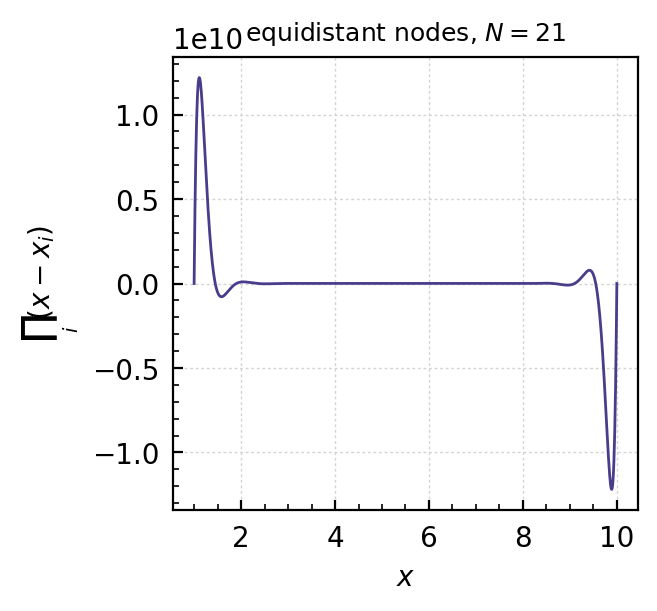

In [33]:
plot_line_points(xt, dxpe1,
                 xlabel=r'$x$', 
                 ylabel=r'$\prod_i(x-x_i)$', figsize=3, 
                 plot_title='equidistant nodes, $N = %d$'%(n+1), grid=True)

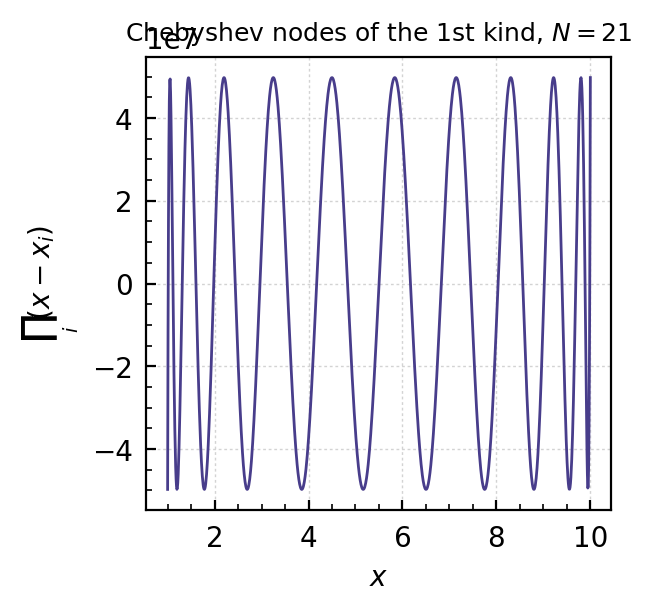

In [34]:
plot_line_points(xt, dxpc1,
                 xlabel=r'$x$', 
                 ylabel=r'$\prod_i(x-x_i)$', figsize=3, 
                 plot_title='Chebyshev nodes of the 1st kind, $N = %d$'%(n+1), grid=True)

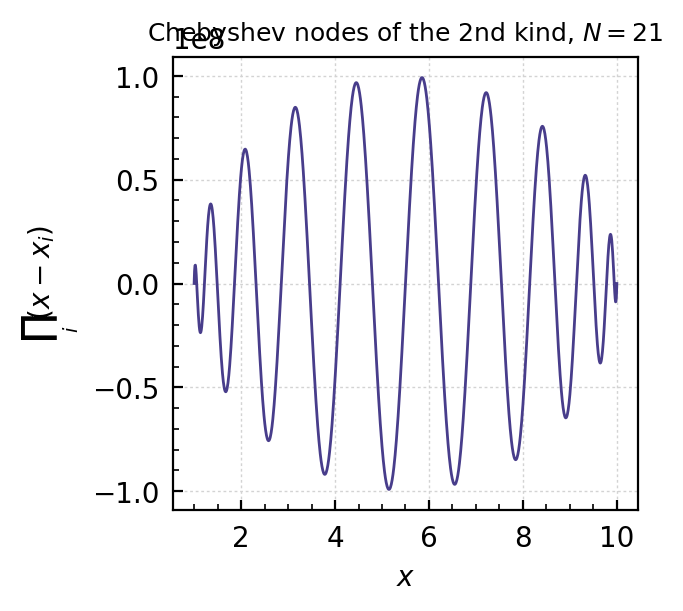

In [35]:
plot_line_points(xt, dxpc2,
                 xlabel=r'$x$', 
                 ylabel=r'$\prod_i(x-x_i)$', figsize=3, 
                 plot_title='Chebyshev nodes of the 2nd kind, $N = %d$'%(n+1), grid=True)

The last two plots for the Chebyshev nodes of the 1st and 2nd kind are actually plots of $T_N(x)/2^N$ and $U_N(x)/2^N$, where $T_N(x)$ and $U_N(x)$ are Chebyshev polynomials of the first and 2nd kind of $N$-th degree. 

### <font color='darkblue'>Chebyshev nodes are the optimal choice for polynomial interpolation

This exercise demonstrates that $\prod_{i=0}^N(x-x_i)$ is quite sensitive to the choice of points $\{x_i\}$. 

In fact, there is a theorem that states that the Chebyshev nodes of the 1st kind produce smallest possible product $\prod_{i=0}^N(x-x_i)$ of all possible choices. Chebyshev nodes of the 2nd kind are also close in accuracy and provide smaller errors near the edges of the interval. 

Thus, ***Chebyshev nodes are the most optimal choice*** for function interpolation or approximation with polynomials. 

### <font color='darkblue'>Theorem on the optimality of the Chebyshev nodes

A set of unique real numbers $-1\leq x_0,\ldots,x_N\leq 1$ that minimizes (i.e., makes it as small as possible) product $\prod_{i=0}^N(x-x_i)$ is the set of Chebyshev nodes of the 1st kind: 

$$x_i=\cos\frac{2k+1}{2(N+1)}\,\pi,\ \ \ \ i=0,\ldots, N$$

and the minimum product value is given by 

$$\prod\limits_{i=0}^N(x-x_i)=\frac{T_N(x)}{2^N},$$

where $T_N(x)$ is Chebyshev polynomial of the first kind of degree $N$. 

This is the statement of the theorem; proof can be found in numerical analysis textbooks. Ask me if you want to see it. 

### <font color='darkblue'>Does it matter which Chebyshev node kind we use?


Note that Chebyshev nodes of the 2nd kind produce approximations that are comparable in accuracy to those obtained with nodes of the 1st kind. The 2nd kind produces somewhat larger errors near the middle of the interval, but much smaller errors near the edges of the interval compared to the nodes of the 1st kind, for which errors are more uniform across the interval. 

In [36]:
xmin, xmax, ntr = -1.9999*np.pi, 1.9999*np.pi, 100
xtr = np.linspace(xmin, xmax, ntr)
ftr = np.sin(xtr)

porder = 10

nt = 1000
xtest = np.linspace(xmin, xmax, nt)


In [37]:
ftest = poly_fit_func(xtr, ftr, xtest, method='poly', porder=porder)

ferr = np.abs(ftest-np.sin(xtest))

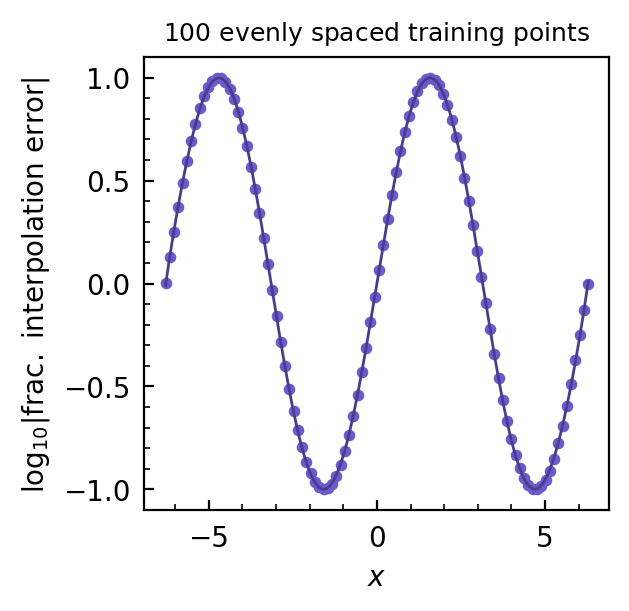

In [38]:
plot_line_points(xtest, ftest,
                 xp = xtr, yp = ftr, 
                 xlabel=r'$x$', points = True, psize=40, 
                 ylabel=r'$\log_{10}\vert\rm frac.\ interpolation\ error\vert$', 
                 plot_title=r'$\rm %d\ evenly\ spaced\ training\ points$'%ntr, figsize=3)


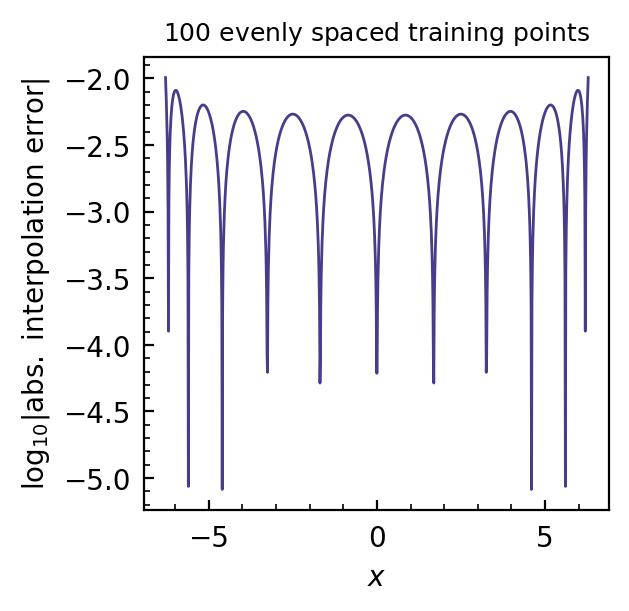

In [39]:
plot_line_points(xtest, np.log10(ferr),
                 xlabel=r'$x$', 
                 ylabel=r'$\log_{10}\vert\rm abs.\ interpolation\ error\vert$', 
                 plot_title=r'$\rm %d\ evenly\ spaced\ training\ points$'%ntr, figsize=3)

In [40]:
def runge(x):
    return 1./(1+x**2)

xtest = np.linspace(xmin, xmax, ntr)
ftest = runge(xtest)

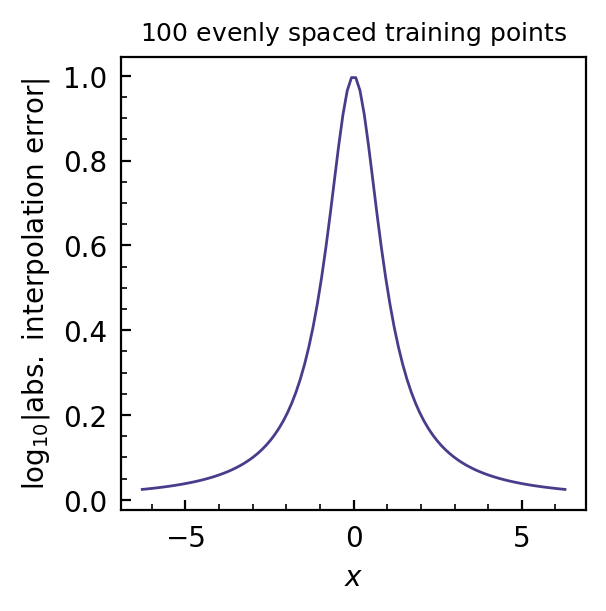

In [41]:
plot_line_points(xtest, ftest,
                 xlabel=r'$x$', 
                 ylabel=r'$\log_{10}\vert\rm abs.\ interpolation\ error\vert$', 
                 plot_title=r'$\rm %d\ evenly\ spaced\ training\ points$'%ntr, figsize=3)



### <font color='darkblue'>Caveats 

* The particular conclusions we reached about polynomial interpolation are applicable to smooth functions. 

* For example, functions with discontinuous first derivatives make accurate polynomial interpolation with equally spaced training points more or less impossible. 

* For non-smooth functions polynomial interpolation with Chebyshev nodes may still work pretty well, but we are not guaranteed to reach machine precision. 

* Choice of interpolation nodes is not always possible (for example, if you deal with data tabulated by someone else). 

* Even for smooth functions with continuous derivatives accurate results can only be guaranteed within the interval of the training set $x\in[x_0,x_N]$. Estimates outside of this interval generally quickly become very inaccurate.

In [42]:
def func(x):
    return 1. / (1. + 12.*x**2)

In [43]:
xmin, xmax, nt = -1., 1., 15

# training point set
xte  = np.linspace(xmin, xmax, nt)
xtc1 = chebyshev_nodes1(xmin, xmax, nt)
xtc2 = chebyshev_nodes2(xmin, xmax, nt)

# a set of test points for plotting
ntt = 1000
xt = np.linspace(-1., 1., ntt)

In [44]:
#assuming nt=15
xte_mm = np.zeros(np.size(xte)-1)
xte_mm[:7] = xte[:7]
xte_mm[7:] = xte[8:]

In [45]:
from scipy.interpolate import barycentric_interpolate

poly_int_e  = barycentric_interpolate(xte, func(xte), xt)
poly_int_c1 = barycentric_interpolate(xtc1, func(xtc1), xt)
poly_int_c2 = barycentric_interpolate(xtc2, func(xtc2), xt)

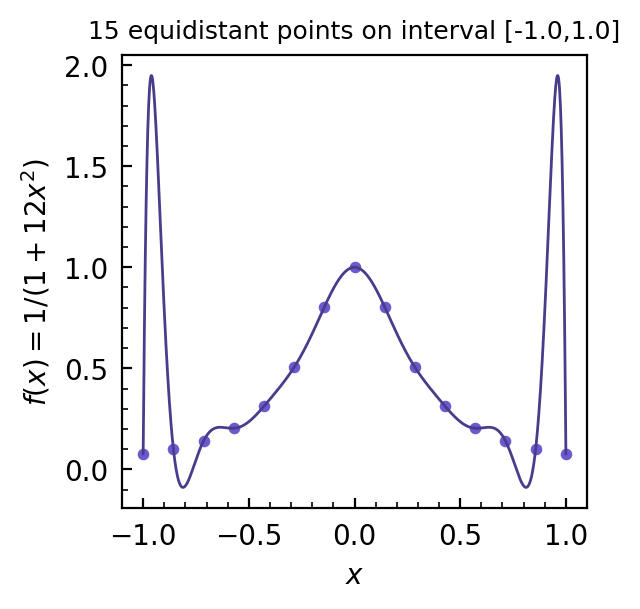

In [46]:
plot_line_points(xt, poly_int_e, xp=xte, yp=func(xte), points=True, psize=40,
                 plot_title = r'%d equidistant points on interval [%.1f,%.1f]'%(nt,xmin,xmax),
                 xlabel=r'$x$', ylabel=r'$f(x)=1/(1+12x^2)$', figsize=3)

**WOW! Approximation looks crazy near the edges, even though it still goes through the training points!**

What you see here is called ***Runge oscillations*** or <a href="https://en.wikipedia.org/wiki/Runge%27s_phenomenon">***Runge phenomenon***</a>... It makes application of polynomial interpolation for evenly spaced training poits all but impossible for functions that change significantly on the scale comparable to separation between training points. 

Runge oscillations were discovered by applied mathematician Carl Runge in 1901.

**However, for the Chebyshev nodes approximation looks good!**

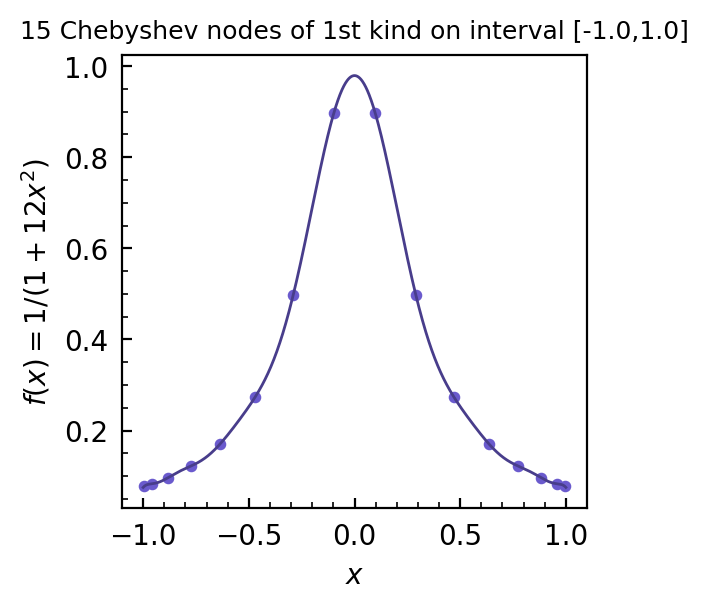

In [47]:
plot_line_points(xt, poly_int_c1, xp=xtc1, yp=func(xtc1), points=True, psize=40, 
                 plot_title = r'%d Chebyshev nodes of 1st kind on interval [%.1f,%.1f]'%(nt,xmin,xmax),
                 xlabel=r'$x$', ylabel=r'$f(x)=1/(1+12x^2)$', figsize=3)

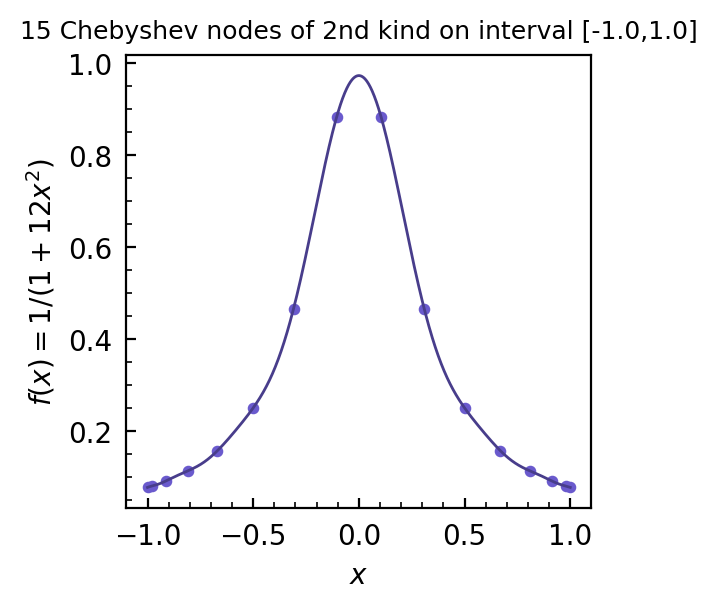

In [48]:
plot_line_points(xt, poly_int_c2, xp=xtc2, yp=func(xtc2), points=True, psize=40, 
                 plot_title = r'%d Chebyshev nodes of 2nd kind on interval [%.1f,%.1f]'%(nt,xmin,xmax),
                 xlabel=r'$x$', ylabel=r'$f(x)=1/(1+12x^2)$', figsize=3)

### <font color='darkblue'>Approximating functions with discontinuities 

The functions that have discontinuities present another challenge due to the effect called ***Gibbs phenomenon*** illustrated below for the "square pulse" function. 

In [49]:
def square_pulse_scalar(x):
    """
    square pulse (aka top-hat) function centered on of width 1.0 
    
    Parameters: 
    x: scalar value
    """
    if x < -0.5 or x > 0.5:
        return 0
    elif (x >= -0.5) & (x < 0.5):
        return 1.

In [50]:
def square_pulse(x, location=0., width=0.5, amplitude=1.):
    """
    the same as above but vectorized, so that function can take x as numpy vector 
    and return vector of evalued function values
    
    Parameters:
        x: numpy vector of floats
        location: center x of the pulse
        width: width of the pulse
        amplitude: amplitude of the pulse
    """
    fsx = np.zeros_like(x)
    fsx[np.abs(x-location) <= width] = amplitude
    return fsx 

In [51]:
xmin, xmax, ntr = -2., 2., 100
xtr = np.linspace(xmin, xmax, ntr)
xtr = chebyshev_nodes2(xmin, xmax, ntr)

ftr = square_pulse(xtr, amplitude=2.)

# fit polynomial of order N
N = ntr
afit = np.polyfit(xtr, ftr, N)
pfit = np.poly1d(afit)

C:\Users\akrav\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3361: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


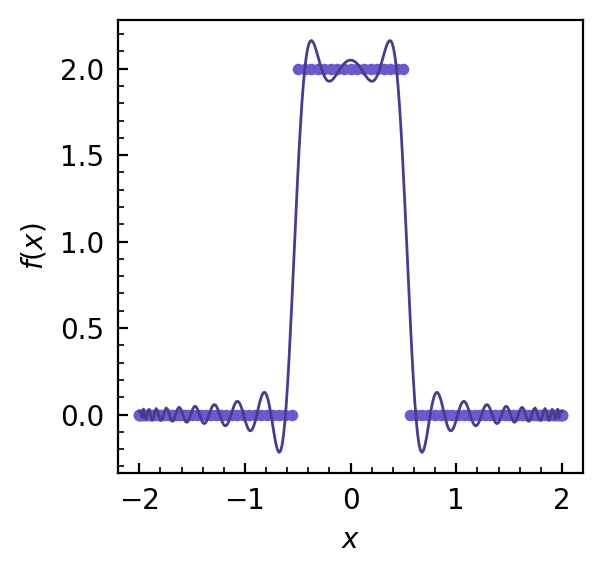

In [52]:
nt = 300
xt = np.linspace(xmin, xmax, nt)
plot_line_points(xt, pfit(xt), xp=xtr, yp=ftr, points=True, psize=40, 
                 xlabel='$x$', ylabel='$f(x)$', figsize=3)

The oscillations in the plot above are called ***Gibbs oscillations*** or <a href="https://en.wikipedia.org/wiki/Gibbs_phenomenon">***Gibbs phenomenon***</a> and arise whenever we try to use polynomial-based or generally expansion basis consisting of continuous functions to approximate discontinuous ones. 

Gibbs phenomenon was actually discovered by mathematician Henry Wilbraham in 1848 while working on his MSc degree at Cambridge University, when he was 23 years old. It was then rediscovered by Josiah Willard Gibbs in 1899 (i.e., 50 years later) close in time to the discovery of Runge phenomenon and has become widely known after that. 

### <font color='darkblue'>Food for thought: what kind of basis would be optimal here to approximate this function?

### <font color='darkblue'>Lessons  

Approximation using polynomial interpolation corresponding to the expansion using polynomials of order equal to the number of training points. The conclusion from this exercise, can be generalized for expansions using other function basis sets. 
    
In approximation of functions using function expansion set, which encompasses nearly all commonly used methods of approximating functions in 1d:

$$f(x)\approx\sum\limits_{k=0}^m a_k\psi_k(x).$$


* Optimal approximation basis  ($\{\psi_k\}$) set depends on the size of the training set, placement of training points, and properties of the approximated function $f(x)$.


* Optimal function basis set ($\{\psi_k\}$) used in approximation uses $\psi_k$ that allow for computationally stable and efficient computation of the coefficients $a_k$ and that provide a natural match to the approximated function: for example, polynomials for smooth polynomial-like functions, square pulses to approximate discontinuous functions, trigonometric functions to approximate periodic functions, etc. 


* A function basis set optimal in the latter sense, will have only a small number of $a_k$ coefficients 

### <font color='darkblue'>Additional reading

Exposition of polynomial interpolation using barycentric method in this notebook follows closely review paper of <a href="https://people.maths.ox.ac.uk/trefethen/barycentric.pdf">Berrut & Trefethen (2010)</a>, where you can find more details on this method, discussions, and references. 

<a href="https://people.maths.ox.ac.uk/trefethen/mythspaper.pdf">Trefethen (2011)</a> - is a nice, short article about polynomial interpolation and its uses, systematically dispelling many of the existing myths and misconceptions about it. 

### <font color='darkblue'>Error of the polynomial approximation: proof 

Suppose function $f(x)$ has $N+1$ continuous derivatives in the interval $x\in [a,b]$. If it is tabulated at $N+1$ distinct points $\{x_i\}$, $i=0,\ldots,N$ by interpolating 
polynomial of order $N$, $p_N(x)$,  the error of the polynomial approximation over this interval can be bounded as follows. 

Consider function
$$
g(\chi) = f(\chi) - p_N(\chi) - [f(x) - p_N(x)]\,\prod\limits_{i=0}^N\frac{(\chi - x_i)}{(x-x_i)},
$$
where $x\ne x_i$ for any $i$. 
If $p_N$ is interpolating polynomial, $g(\chi=x_i) = 0$ for any $i$ and thus $g(\chi)$ has at least $N+1$ zeroes (roots) on $[a,b]$. In addition, it has another zero at $\chi = x$ as can be easily seen from the above equation and thus $g(\chi)$ has at least $N+2$ distinct zeroes on the interval. Between each pair of zero points $g^\prime = dg/d\chi$ must change sign and so $g^\prime$ must have zero on the $N+1$ intervals formed by the zeroes of $g(\chi)$. The same logic applied to the $N+1$ zeros of $g^\prime$ leads to the conclusion that $g^{\prime\prime}$ has $N$ zeroes, and so on until we conclude that $g^{(N+1)}$ has one zero at some $\chi=\xi$. Note that $(N+1)$-th derivative of $p_N(\chi)$ is zero and that the leading (largest power) term of expanded $\prod_{i=0}^N(\chi-x_i)$ will be $\chi^{N+1}$ and so the $(N+1)$-th derivative of this product will be $(N+1)!$ and so
$$
\frac{d^{N+1}g(\xi)}{d\chi^{N+1}} = 0 = \frac{d^{N+1}f(\xi)}{d\chi^{N+1}}  - [f(x) - p_N(x)]\,\frac{(N+1)!}{\prod_{i=0}^N(x-x_i)},
$$
which gives
$$
\epsilon(x) = f(x) - p_N(x) = \frac{f^{(N+1)}(\xi)}{(N+1)!}\,\prod_{i=0}^N(x-x_i),
$$
where $\xi$ is a point within interval $[a,b]$. 


### <font color='darkblue'>Approximation by a polynomial is a special case of approximation via basis function expansion 

$$f(x)\approx \sum\limits_{k=0}^m a_k\psi_k(x),$$

where $a_k$ are some coefficients to be determined and are sometimes called *components* of $f(x)$. 

The basis functions $\psi_k$ must be *linearly independent*, which means that the sum $\sum_{k=0}^m a_k\psi_k(x)=0$ for any $x$ only when $a_k=0$ for all $k$. The linear independence requirement is to ensure that general $f(x)\ne 0$ can be represented by the sum.

For example, one can think of piecewise approximation of the function as such expansion, where approximation in each of the interval $[x_i,x_{i+1})$ corresponds to one term in the above expansion. This is similar to how areas of trapezoids in trapezoidal integration are summed to calculate the total integral estimate. 

## <font color='darkblue'>Function approximation by regression

Interpolation can be thought of as a special case of general function approximation when the number of terms in the expansion is equal to the number of training points. 

In general, we can use fewer terms, but to determine coefficients $a_k$ in the expansion series we need some extra constraints. Various choices are possible. The most common approach is to define a metric and determine the values of  $\{a_k\}$ that minimize it. 

One of the easiest metrics to deal with is square of the residual $r_i=f_i-\sum a_k\psi_k(x_i)$ (recall $\chi^2$ as objective measure of the "fit quality"): 

$$
E_2 = \sum\limits_{i=0}^{N}w(x_i)\left[{f}_i - \sum\limits_{k=0}^m a_k\psi_k(x_i)\right]^2,
$$

where $w(x)\geq 0$ is a weight function, which can allow us to give larger or smaller weight to certain values ${f}_i$.  Note that weights for different $x_i$ are assumed to be independent of each other here.

Treatment of correlated weights is straightforward, but mathematically more complicated (requires dealing with matrix notation throughout). If you are interested to learn how this is done in this case, please let me know. 

The advantage this metric has over, say, the 
metric which is defined using sum of absolute values of the residuals $r_i$ is that $E_2$ is differentiable everywhere

Thus, we can use  derivatives of $E_2$ with respect to coefficients to find minimum of $E_2$: 

$$
\frac{\partial E_2}{\partial a_j} = -2 \sum\limits_{i=0}^{N}w(x_i)\left[{f}_i - \sum\limits_{k=0}^m a_k\psi_k(x_i)\right]\psi_j(x_i)
$$

$a_j$ value minimizes $E_2$ if $\partial E_2/\partial a_j=0$ or

$$
\sum\limits_{i=0}^{N}w(x_i)\left[{f}_i - \sum\limits_{k=0}^m a_k\psi_k(x_i)\right]\psi_j(x_i)=0.
$$

We can write down $m+1$ such equations for $m+1$ coefficients (called *normal equations*). 

The normal equations require care in their solution, as they can be prone to the unstabilities similar to those encountered in matrix inversion. The most stable methods are based on the QR decomposition and Singular Value Decomposition (SVD) and these are usually used in library functions. 

### <font color='darkblue'>Orthogonal basis function sets

For special cases of function sets $\{\psi_k\}$, called *orthogonal functions* computation of $a_k$ coefficients is greatly simplified.
    
Such  functions satisfy the orthogonality condition: 
$$
\sum\limits_{i=0}^{N}w(x_i)\psi_k(x_i)\psi_j(x_i)=0, \ \ \ \mathrm{if}\ \ j\ne k.
$$

When this expression is also equal to $1$ for $j=k$ the basis set is called *orthonormal*. 

If we examine normal equations closely 
$$
\sum\limits_{i=0}^{N}w(x_i)\left[f_i - \sum\limits_{k=0}^m a_k\psi_k(x_i)\right]\psi_j(x_i)=0.
$$

it is possible to show that these can be greately simplified for the orthogonal function basis sets.

#### <font color='darkblue'>Derivation of the normal equations for orthogonal function basis

\begin{eqnarray}
0&=&\sum\limits_{i=0}^{N}w_i\left[f_i - \sum\limits_{k=0}^m a_k\psi_k(x_i)\right]\psi_j(x_i)=\sum\limits_{i=0}^{N}w_if_i \psi_j(x_i) - \sum\limits_{i=0}^{N}w_i\sum\limits_{k=0}^m a_k\psi_k(x_i)\psi_j(x_i)\nonumber\\
& =& \sum\limits_{i=0}^{N}w_if_i \psi_j(x_i) - \sum\limits_{k=0}^{m}a_k \sum\limits_{i=0}^N w_i\psi_k(x_i)\psi_j(x_i) = \sum\limits_{i=0}^{N}w_if_i \psi_j(x_i) - a_j  \sum\limits_{i=0}^N w_i\psi_j^2(x_i),
\end{eqnarray}
where $w_i=w(x_i)$. 


\begin{equation} 
a_j = \frac{\sum\limits_{i=0}^{N}w_if_i \psi_j(x_i) }{\sum\limits_{i=0}^N w_i\psi_j^2(x_i)},
\end{equation}

which requires $O(m\times N)$ operations for all coefficients (where the "big O" notation means "of order of"). We can then have our approximation of $f(x)$ using these coefficients $f(x)=\sum_k a_k\psi_k(x)$.

### <font color='darkblue'>Example: piecewise constant approximation of a function

If we approximate $f(x)$ for $x\in[a,b]$ using a sum of $m$ piecewise constant functions $\psi_k$ that are equal to 1 within a subinterval of $[a,b]$ and 0 elsewhere, such $\psi_k$ form an orthonormal basis. 


If we choose $m=1$,   our approximation is simply:
\begin{equation} 
f(x)\approx a_0\phi_0(x) = a_0\phi(x) = a_0 = \frac{\sum\limits_{i=0}^{N}w_i f_i }{\sum\limits_{i=0}^N w_i},
\end{equation}
where eq. for orthogonal basis set coefficients was used for $a_0$, taking into account that $\phi_0=\phi(x)=1$ over the entire interval.

The latter expression above corresponds to the weighted average of the tabulated values $f_i$ over the entire interval. There is no $x$ dependence and so this approximation is a constant equal to the weighted average. 

Likewise, for $m=2$, 
\begin{equation} 
f(x)\approx a_0\phi_0(x) + a_1\phi_1(x), 
\end{equation}
where $\phi_0(x)=1$ over the first half of the tabulated interval and zero elsewhere, and $\phi_1(x)=1$ over the second half of the interval and is zero elsewhere. 

The coefficients will be

\begin{equation} 
a_0 = \frac{\sum\limits_{i=0}^{N}w_i f_i \phi_k(x_i )}{\sum\limits_{i=0}^N w_i\phi_k^2(x_i)} = \frac{\sum\limits_{x_i\in [a,a+(b-a)/2}^{N}w_i f_i}{\sum\limits_{x_i\in [a,a+(b-a)/2]}^N w_i},
\end{equation}

\begin{equation} 
a_1 = \frac{\sum\limits_{i=0}^{N}w_i f_i \phi_k(x_i )}{\sum\limits_{i=0}^N w_i\phi_k^2(x_i)} = \frac{\sum\limits_{x_i\in [a+(b-a)/2,b]}^{N}w_i f_i}{\sum\limits_{x_i\in [a+(b-a)/2,b]}^N w_i},
\end{equation}

Equations above show that coefficients $a_k$ will be the weighted averages of $f_i$ over the corresponding sub-interval of $x$.
In other words, we have approximated our function by the piecewise constant function of $m$ segments. 


Notice that we can use any function that is non-zero for $x\in [0,1)$ and zero elsewhere instead of $\phi(x)$ and use the same machinery as the above to construct piecewise approximation of a function that is different than constant in each segment. 


### <font color='darkblue'>Example: piecewise linear approximation of a function

***Note:*** this is approximation for $f(x)$ used in the trapezoidal integration scheme. 

Consider another basis set for approximating $N+1$ values of the function $f(x)$: $\{f_i=f(x_i)\}$, $i=0,\ldots, N$, tabulated on $x_i\in[a,b)$, $x_0<x_1<\ldots<x_N$, of the following form for $i=1,\ldots,N-1$: 
\begin{equation}
\psi_i(x) = 
\begin{cases}
1 - (x-x_{i-1})/(x_{i}-x_{i-1})&\ \ \mathrm{for}\ \ x_{i-1}< x \leq x_{i}\\
1 - (x_{i+1}-x)/(x_{i+1}-x_{i})&\ \ \mathrm{for}\ \ x_{i}< x \leq x_{i+1}\\
0 &\ \ \mathrm{otherwise}.
\end{cases}
\label{eq:pwlinbasis}
\end{equation}
and for $i=0$ and $i=N$: 
\begin{equation}
\psi_0(x) = 
\begin{cases}
1 - (x_1-x)/(x_1-x_0)&\ \ \mathrm{for}\ \ x_0\leq x \leq x_1\\
0 &\ \ \mathrm{otherwise}.
\end{cases}
\end{equation}
\begin{equation}
\psi_N(x) = 
\begin{cases}
1 - (x-x_{N-1})/(x_N-x_{N-1})&\ \ \mathrm{for}\ \ x_{N-1}< x \leq x_N\\
0 &\ \ \mathrm{otherwise}.
\end{cases}
\end{equation}
These basis functions are linear polynomials of $x$ that are localized around each $x_i$. This expansion will therefore 
give a piecewise approximation for $f(x)$. The basis functions $\psi_i$ and $\psi_{i+1}$ are positive and overlap in $x$ and therefore this set of basis functions is not orthogonal. However, in this particular case the coefficients of the expansion are trivially obtained.  

It is easy to see that for this definition 
\begin{equation}
\psi_i(x_j) = 
\begin{cases}
1, &\ \ \mathrm{for}\ \ i=j\\
0,&\ \ \mathrm{for}\ \  i\ne j\\ 
\end{cases}
\end{equation}
and thus for the expansion
\begin{equation}
f(x)\approx s(x)=\sum\limits_{k=0}^N a_k\psi_k(x)
\end{equation}
$s(x_j) = a_j$ and so to match tabulated values of $f$ all we need to do is to set $a_k=f_k = f(x_k)$. 
Thus, the piecewise-linear interpolating approximation of the function is given by the expansion
\begin{equation}
f(x)\approx \sum\limits_{k=0}^N f_k\psi_k(x).
\end{equation}

### <font color='darkblue'>Widely used special orthogonal function bases

For some choices of nodes $\{x_i\}$ and weight function $w(x)$ the sets of orthogonal functions are known. 
    
For example, *for evenly spaced  $\{x_i\}$ and all $w(x_i)=1$* the orthogonal basis is  discrete orthogonal Chebyshev polynomials (also often called Gram polynomials after Joergen Gram, who re-discovered them some 30 years after Chebyshev, e.g., see S 2.1.3.11 <a href="https://www.springer.com/cda/content/document/cda_downloaddocument/9783540683469-c2.pdf?SGWID=0-0-45-604825-p173825732">here</a>).  
    
Another orthogonal basis for evenly spaced data is trigonometric series and Fourier series that will be considered after polynomial and spline interpolation. 

However, we do not always have the luxury of dealing with evenly spaced, equal weight data. For example, a common task in day-to-day data analyses is to approximate a set of noisy data, where noise is not uniform (varies from point to point) and is due to measurement error or limited statistics. In such case, each data point should have a different weight that is customarily taken to be inverse of its uncertainty squared: $w_i=1/\sigma^2_i$. 

Thus, for the above least squares solution with orthogonal discrete polynomials to be useful, we have to have a way to get such orthogonal polynomials for an arbitrary set of $\{x_i\}$ and $\{w_i\}$. The Gram-Schmidt process for constructing such orthogonal polynomial sets for an arbitrary set of $\{x_i\}$ and $\{w_i\}$ is described below. 
    
Piecewise polynomial approximation of functions using expansion series with $B$-spline basis functions is one of the most common methods of approximation used in practice due to a combination of accuracy and numerical stability of such approximations. These methods also work for arbitrary $\{x_i\}$ and $\{w_i\}$ and will be considered in the next notebook.

### <font color='darkblue'>The Gram-Schmidt orthogonalization process for polynomials

For the general $\{ x_i\}$ and $\{w_i\}$, including non-uniform spacing of $x_i$ and individual values of $w_i$ for each data point, it is possible to construct a set of orthogonal polynomials using *the Gram-Schmidt orthogonalization process*. 

Below the algorithm that expresses the Gram-Schmidt method for polynomial regression is presented without proof. You can find a detailed derivation and logic of it at the end of this notebook.  


### <font color='darkblue'>Constucting discrete orthogonal polynomials using Gram-Schmidt method

To construct a set of $m+1$ discrete polynomials, $p_k$ (i.e., $\{\psi_k\}=\{p_k\}$), orthogonal on $N+1$ points $\{ x_i\}$ with weights $\{w_i\}$: 

**1.** start with a simplest polynomial of $0$-th order, $p_0(x)=x^0=1$, and construct the linear polynomial orthogonal to it,  $p_1(x)=(x-\alpha_1)\,p_0(x) = x - \alpha_1$, with $\alpha_1$ derived using the orthogonality condition:

$$
 \sum\limits_{i=0}^{N}w(x_i)p_1(x_i)p_0(x_i)=\sum\limits_{i=0}^{N}w(x_i)(x_i-\alpha_1)=0,
$$

which gives 

$$\alpha_1 = \frac{\sum\limits_{i=0}^{N} w_i x_i}{\sum\limits_{i=0}^{N} w_i}.$$ 

**2.**  Continue constructing polynomials of higher order using the following recurrence relation:

$$
p_{k+1}(x) = (x-\alpha_{k+1})\,p_k(x) - \beta_k\, p_{k-1}(x),
$$

where expressions for $\alpha_{k+1}$ and $\beta_k$ are derived from the orthogonality conditions: 

$$
\alpha_{k+1}=\frac{\sum\limits_{i=0}^{N}w_i x_i\, p_k^2(x_i)}{\sum\limits_{i=0}^{N}w_i\, p_k^2(x_i)};\ \ \ \ \ \ \beta_k=\frac{\sum\limits_{i=0}^{N}w_i\, p_k^2(x_i)}{\sum\limits_{i=0}^{N}w_i\, p_{k-1}^2(x_i)},
$$

### <font color='darkblue'>Gram-Schmidt process summary

Approximation of $f(x)$ tabulated at points $\{x_i\}$ with values $\{\tilde{f}_i\}$ and weights $\{w_i\}$ thus consists of evaluating the sum 

$$
f(x)\approx \sum\limits_{k=0}^m a_k\psi_k(x),
$$

with $\psi_k(x)=p_k(x)$, where $p_k$ is derived using recurrence relation above starting with $p_0=1$ (convenient for coding is also to assume $p_{-1}=0$) and coefficients $a_k$ given by 

$$a_k = \frac{\sum\limits_{i=0}^{N}w(x_i)\,f_i\, p_k(x_i) }{\sum\limits_{i=0}^N w(x_i)\,p_k^2(x_i)},$$
    
This algorithm can be implemented fairly straightforwardly in a function that can be used for general polynomial regression and interpolation. 

### <font color='darkblue'>Example of polynomial regression

Figure below shows example of using polynomial regression with the Gram-Schmidt computed polynomials for the luminosity distribution of galaxies you've been examining in hw 3. 
    
<img width=400 src="https://astro.uchicago.edu/~andrey/classes/a211/img/poly_regression_lumfunc_m10.png"></img>

### <font color='darkblue'>Derivation of the Gram-Schmidt process

---------------------------------
***This is a technical info on derivation of the equations of the Gram-Schmidt process and is optional. You don't need it to use the process and thus you can skip it, unless you are curious about how the equations using in this method are derived and justified.*** 

---------------------------------

Let us start with the zeroth order polynomial $p_0(x)=x^0=1$ and suppose we want to determine a sequence of polynomials starting with $p_0$, which have leading highest order term with coefficient of unity $i.e., p_k(x) = x^k + \sum_{j=0}^{k-1}b_j x^j$. We can get the linear polynomial of this kind, $p_1(x)$ by multiplying $p_0=1$ by $x-\alpha_1$: $p_1(x)=(x-\alpha_1)p_0(x) = x - \alpha_1$. The coefficient $\alpha_1$ can then be determined from the orthogonality condition: 
\begin{equation}
 \sum\limits_{i=0}^{N}w(x_i)p_1(x_i)p_0(x_i)=\sum\limits_{i=0}^{N}w(x_i)(x_i-\alpha_1)=0,
\end{equation}
which gives $\alpha_1 = \sum_i w_i x_i/\sum_i w_i$, where $w_i=w(x_i)$. 

To construct polynomial of the next order, we can try a similar approach: $p_2(x) = (x-\alpha_2)p_1(x)$. Orthogonality condition with $p_1$ will give the coefficient
\begin{equation}
 \sum\limits_{i=0}^{N}w_ip_2(x_i)p_1(x_i)=\sum\limits_{i=0}^{N}w_i(x_i-\alpha_2)p_1^2(x_i)=0,\ \ \ \rightarrow \alpha_2 = \frac{\sum\limits_{i=0}^{N}w_i x_i p_1^2(x_i)}{\sum\limits_{i=0}^{N}w_i p_1^2(x_i)}.
\end{equation}
However, we also need to ensure that $p_2$ is orthogonal to $p_0$ and this is not guaranteed with the above $\alpha_2$. For this reason, let us instead define
the quadratic polynomial as $p_2(x)=(x-\alpha_2)p_1(x) - \beta_1 p_0(x)$. In this case orthogonality condition with $p_1$ will still result in the same $\alpha_2$ as $\beta_1\sum_i w_i p_1(x_i)p_0(x_i)=0$ by construction of $p_1$, while the presence of $\beta_1p_0(x)$ term in the definition of $p_2(x)$ will allow us to ensure orthogonality to $p_0(x)$: 
\begin{equation}
 \sum\limits_{i=0}^{N}w_i p_2(x_i) p_0(x_i)=\sum\limits_{i=0}^{N}w_i\left[(x_i-\alpha_2)p_1(x_i) - \beta_1 p_0(x_i)\right]p_0(x_i)=0,
\end{equation}
which gives
\begin{equation}
\beta_1 = \frac{\sum\limits_{i=0}^{N}w_ix_i p_1(x_i)p_0(x_i)}{\sum\limits_{i=0}^{N}w_i p_0^2(x_i)}=\frac{\sum\limits_{i=0}^{N}w_i x_i p_1(x_i)}{\sum\limits_{i=0}^{N}w_i}.
\end{equation}

We can continue constructing polynomials of higher order using a similar recurrence relation
\begin{equation}
p_{k+1}(x) = (x-\alpha_{k+1})p_k(x) - \beta_k p_{k-1}(x).\ \ \ \ \ (1)
\end{equation}
It is clear that this definition can ensure orthogonolaity of $p_{k+1}$ to $p_k$ and $p_{k-1}$ given $\alpha_{k+1}$ and $\beta_k$ determined using orthogonality conditions as for $p_2$ above: 
\begin{equation}
\alpha_{k+1}=\frac{\sum\limits_{i=0}^{N}w_i x_i p_k^2(x_i)}{\sum\limits_{i=0}^{N}w_i p_k^2(x_i)};\ \ \ \ \ \ \beta_k=\frac{\sum\limits_{i=0}^{N}w_i x_i p_{k-1}p_k(x_i)}{\sum\limits_{i=0}^{N}w_i p_{k-1}^2(x_i)}=\frac{\sum\limits_{i=0}^{N}w_i p_k^2(x_i)}{\sum\limits_{i=0}^{N}w_i p_{k-1}^2(x_i)},\ \ \ \ (2)
\end{equation}
where the last equality for $\beta_k$ is derived using equation 1. However, we also need to prove that $p_{k+1}$ with such coefficients is orthogonal to all previously constructed orthogonal polynomials $\{p_j\}$ for $j=0,\ldots,k-2$.

Considering 
\begin{equation}
 \sum\limits_{i=0}^{N}w_i p_j(x_i)p_{k+1}(x_i)=\sum\limits_{i=0}^{N} w_i x_ip_j(x_i)p_k(x_i) - \alpha_{k+1} \sum\limits_{i=0}^{N}w_i p_j(x_i)p_k(x_i) - \beta_{k}\sum\limits_{i=0}^{N}w_i p_j(x_i)p_{k-1}(x_i) 
\end{equation}
for $j=0,\ldots, k-2$, we see that the last two terms are zero because $p_j$ for these $j\leq k$ are already constructed to be orthogonal. In the first term, 
factor $x_i p_j(x_i)$ is a polynomial in $x_i$ of order $\leq k-1$ and it thus can be expressed as a linear combination of polynomials of $p_j$ with $j=0,\ldots, k-1$. 
Substituting such linear combination into the first term will result in a sum, in which each term is zero by the already established orthogonality conditions for $j\leq k$ and thus the first term is also zero. Hence, $p_{k+1}$ constructed using equation (1) with coefficients given by equations (2) is orthogonal to all 
$p_j$ constructed in a similar way with $j\leq k$. 

### Additional reading: 

Material on approximating functions with the series of orthogonal functions closely follows material in Sections 6.2-6.4 of a book by <a href="https://www.amazon.com/First-Course-Numerical-Analysis-Publications/dp/B00M3SOX0K">Ralston & Rabinowitz (2001).</a>